Author: Mark McDonnell, mark.mcdonnell@unisa.edu.au

This notebook demonstrates the use of "Leave One City Out Cross validation"

In [1]:
model_name = 'final_LOCO' 

In [2]:
#select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [4]:
#imports 
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from scipy.io import savemat,loadmat
import soundfile as sound
import librosa

import tensorflow
from tensorflow.keras.optimizers import SGD

print("keras version = ",tensorflow.keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

sys.path.insert(0, "../")
from NNets import model_resnet_DCASE2020_Task1b
from DCASE_training_functions_v2 import LR_WarmRestart, MixupGenerator
from DCASE_plots import plot_confusion_matrix


keras version =  2.2.4-tf
tensorflow version =  1.13.1


In [5]:
#source data attributes
sr = 48000
num_audio_channels = 2
SampleDuration = 10 #seconds

#log-mel spectrogram parameters
NumFreqBins = 256
NumFFTPoints = 4096
HopLength = int(NumFFTPoints/4)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

#training parameters
init_lr = 0.025
mixup_alpha = 0.4
crop_length = 400

#model parameters
wd = 5e-4
num_filters=26


In [6]:
meta_df = pd.read_csv('../../Data/TAU-urban-acoustic-scenes-2020-3class-development/meta.csv',sep='\t', encoding='ASCII')

ClassNames = np.unique(meta_df['scene_label'])
NumClasses = len(ClassNames)
print(ClassNames)

meta_df['city']=[aa.split('-')[1] for aa in meta_df['filename'].get_values()]
meta_df['subclass']=[aa.split('-')[0][6::] for aa in meta_df['filename'].get_values()]
meta_df['location_id']=[aa.split('-')[2] for aa in meta_df['filename'].get_values()]
meta_df['segment']=[aa.split('-')[3]  for aa in meta_df['filename'].get_values()]
meta_df['label'] =  meta_df['scene_label'].astype('category').cat.codes.values
meta_df.head()

['indoor' 'outdoor' 'transportation']


,filename,scene_label,identifier,source_label,city,subclass,location_id,segment,label
0,audio/airport-lisbon-1000-40000-a.wav,indoor,lisbon-1000,a,lisbon,airport,1000,40000,0
1,audio/bus-lyon-1001-40001-a.wav,transportation,lyon-1001,a,lyon,bus,1001,40001,2
2,audio/shopping_mall-lisbon-1002-40002-a.wav,indoor,lisbon-1002,a,lisbon,shopping_mall,1002,40002,0
3,audio/street_pedestrian-lyon-1003-40003-a.wav,outdoor,lyon-1003,a,lyon,street_pedestrian,1003,40003,1
4,audio/street_pedestrian-lisbon-1004-40004-a.wav,outdoor,lisbon-1004,a,lisbon,street_pedestrian,1004,40004,1


In [7]:
cities,counts = np.unique(meta_df['city'].get_values(),return_counts=True)
print(cities)
print(counts)

#there are 514 unique locations
locs,counts = np.unique(meta_df['location_id'].get_values(),return_counts=True)
print(len(locs))

['barcelona' 'helsinki' 'lisbon' 'london' 'lyon' 'milan' 'paris' 'prague'
 'stockholm' 'vienna']
[1421 1447 1440 1444 1440 1440 1452 1440 1456 1420]
514


In [9]:
Spectograms_all=np.load('Task1b_LM_train_'+str(NumFreqBins)+'_'+str(NumFFTPoints)+'_all.npy')
LogMelSpectograms_all = np.log(Spectograms_all+1e-8)
print(LogMelSpectograms_all.shape,[NumFreqBins,NumTimeBins,num_audio_channels])

(14400, 256, 469, 2) [256, 469, 2]


In [10]:
Y0 = tensorflow.keras.utils.to_categorical(meta_df['label'], NumClasses)
Y0.shape

(14400, 3)

In [11]:
def metric_balanced_accuracy_score(y_true, y_pred):
    from sklearn.metrics import balanced_accuracy_score
    import tensorflow as tf
    from tensorflow.keras import backend as K
    return tf.py_function(balanced_accuracy_score, (K.argmax(y_true,-1), K.argmax(y_pred,-1)), tf.double)


In [16]:
NumGPUs=1
batch_size_per_GPU=32
for city_to_leave_out in cities:

    Val_df = meta_df[meta_df['city']==city_to_leave_out]
    Train_df = meta_df[meta_df['city']!=city_to_leave_out]
    
    Val_inds = Val_df.index
    Train_inds = Train_df.index
    X_val=LogMelSpectograms_all[Val_inds,:,:,:]
    Y_val=Y0[Val_inds,:]
    X_train=LogMelSpectograms_all[Train_inds,:,:,:]
    Y_train=Y0[Train_inds,:]
    print(city_to_leave_out,X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)
 
    #define and compile the model
    model = model_resnet_DCASE2020_Task1b(NumClasses,
                         input_shape =[NumFreqBins,None,num_audio_channels], 
                         num_filters =num_filters,
                         wd=wd,binarise_weights=True)
    
    model.compile(loss='categorical_crossentropy',
                      optimizer =SGD(lr=init_lr,decay=0, momentum=0.9, nesterov=False),
                      metrics=['accuracy',metric_balanced_accuracy_score])


    batch_size=32

    #create data generator and callbacks
    TrainDataGen = MixupGenerator(X_train, 
                                      Y_train, 
                                      batch_size=batch_size,
                                      alpha=mixup_alpha,
                                      crop_length=crop_length,
                                 UseBalance=True)

    steps_per_epoch =TrainDataGen.__len__()

    lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                                      initial_lr=init_lr, min_lr=init_lr*1e-4,
                                      epochs_restart = [1.0,11.0,31.0,71.0,151.0],Tmults=[10.0,20.0,40.0,80.0,160.0]) 
    callbacks = [lr_scheduler]

    #train the model
    history = model.fit_generator(TrainDataGen,
                                  validation_data=(X_val, Y_val),
                                  epochs=310, 
                                  verbose=1, 
                                  workers=1,
                                  max_queue_size = 100,
                                  callbacks=callbacks,
                                  steps_per_epoch=steps_per_epoch
                                  )
    
 
    model.save_weights('Models/Task1B_LOO'+city_to_leave_out+'_1gpu_'+model_name+'_310epochs.h5') 

barcelona (12979, 256, 469, 2) (12979, 3) (1421, 256, 469, 2) (1421, 3)
Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.025000
Epoch 1/310
  32/1421 [..............................] - ETA: 1:17 - loss: 7.4712 - acc: 0.0000e+00 - metric_balanced_accuracy_score: 0.0000e+00

/home/mdmcdonn/anaconda3/envs/April2019/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


1421/1421 [==============================] - 10s 7ms/sample - loss: 4.6788 - acc: 0.5595 - metric_balanced_accuracy_score: 0.5642

 End of Epoch Learning Rate = 0.024388
182/182 [==============================] - 128s 704ms/step - loss: 4.0382 - acc: 0.7139 - metric_balanced_accuracy_score: 0.7207 - val_loss: 4.6594 - val_acc: 0.5595 - val_metric_balanced_accuracy_score: 0.5642

 Start of Epoch Learning Rate = 0.024388
Epoch 2/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 3.5788 - acc: 0.6770 - metric_balanced_accuracy_score: 0.6681

 End of Epoch Learning Rate = 0.022613
182/182 [==============================] - 117s 645ms/step - loss: 3.6255 - acc: 0.7826 - metric_balanced_accuracy_score: 0.7897 - val_loss: 3.5737 - val_acc: 0.6770 - val_metric_balanced_accuracy_score: 0.6681

 Start of Epoch Learning Rate = 0.022613
Epoch 3/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 3.4945 - acc: 0.6418 - metric_balanced_accuracy_score: 0.6545

 


 Start of Epoch Learning Rate = 0.014456
Epoch 20/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 1.4705 - acc: 0.8332 - metric_balanced_accuracy_score: 0.8356

 End of Epoch Learning Rate = 0.012501
182/182 [==============================] - 117s 641ms/step - loss: 1.5372 - acc: 0.9040 - metric_balanced_accuracy_score: 0.9084 - val_loss: 1.4680 - val_acc: 0.8332 - val_metric_balanced_accuracy_score: 0.8356

 Start of Epoch Learning Rate = 0.012501
Epoch 21/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 1.5311 - acc: 0.7776 - metric_balanced_accuracy_score: 0.7720

 End of Epoch Learning Rate = 0.010546
182/182 [==============================] - 117s 641ms/step - loss: 1.4945 - acc: 0.8978 - metric_balanced_accuracy_score: 0.9024 - val_loss: 1.5335 - val_acc: 0.7776 - val_metric_balanced_accuracy_score: 0.7720

 Start of Epoch Learning Rate = 0.010546
Epoch 22/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 1.3773 -


 Start of Epoch Learning Rate = 0.022613
Epoch 39/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 1.2385 - acc: 0.7544 - metric_balanced_accuracy_score: 0.7605

 End of Epoch Learning Rate = 0.022005
182/182 [==============================] - 117s 641ms/step - loss: 0.8880 - acc: 0.9068 - metric_balanced_accuracy_score: 0.9100 - val_loss: 1.2281 - val_acc: 0.7544 - val_metric_balanced_accuracy_score: 0.7605

 Start of Epoch Learning Rate = 0.022005
Epoch 40/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.7596 - acc: 0.8691 - metric_balanced_accuracy_score: 0.8682

 End of Epoch Learning Rate = 0.021339
182/182 [==============================] - 117s 641ms/step - loss: 0.8585 - acc: 0.9073 - metric_balanced_accuracy_score: 0.9133 - val_loss: 0.7621 - val_acc: 0.8691 - val_metric_balanced_accuracy_score: 0.8682

 Start of Epoch Learning Rate = 0.021339
Epoch 41/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.8735 -


 Start of Epoch Learning Rate = 0.005971
Epoch 58/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.4457 - acc: 0.8994 - metric_balanced_accuracy_score: 0.9031

 End of Epoch Learning Rate = 0.005155
182/182 [==============================] - 117s 641ms/step - loss: 0.5657 - acc: 0.9342 - metric_balanced_accuracy_score: 0.9383 - val_loss: 0.4435 - val_acc: 0.8994 - val_metric_balanced_accuracy_score: 0.9031

 Start of Epoch Learning Rate = 0.005155
Epoch 59/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.6219 - acc: 0.8459 - metric_balanced_accuracy_score: 0.8422

 End of Epoch Learning Rate = 0.004384
182/182 [==============================] - 117s 641ms/step - loss: 0.5635 - acc: 0.9334 - metric_balanced_accuracy_score: 0.9375 - val_loss: 0.6178 - val_acc: 0.8459 - val_metric_balanced_accuracy_score: 0.8422

 Start of Epoch Learning Rate = 0.004384
Epoch 60/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.5353 -


 Start of Epoch Learning Rate = 0.024655
Epoch 77/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.6117 - acc: 0.7755 - metric_balanced_accuracy_score: 0.7643

 End of Epoch Learning Rate = 0.024531
182/182 [==============================] - 116s 637ms/step - loss: 0.5332 - acc: 0.9160 - metric_balanced_accuracy_score: 0.9208 - val_loss: 0.6171 - val_acc: 0.7755 - val_metric_balanced_accuracy_score: 0.7643

 Start of Epoch Learning Rate = 0.024531
Epoch 78/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.4403 - acc: 0.8614 - metric_balanced_accuracy_score: 0.8592

 End of Epoch Learning Rate = 0.024388
182/182 [==============================] - 116s 638ms/step - loss: 0.5170 - acc: 0.9191 - metric_balanced_accuracy_score: 0.9235 - val_loss: 0.4392 - val_acc: 0.8614 - val_metric_balanced_accuracy_score: 0.8592

 Start of Epoch Learning Rate = 0.024388
Epoch 79/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.5884 -


 Start of Epoch Learning Rate = 0.019445
Epoch 96/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3405 - acc: 0.8600 - metric_balanced_accuracy_score: 0.8553

 End of Epoch Learning Rate = 0.019032
182/182 [==============================] - 116s 636ms/step - loss: 0.4266 - acc: 0.9373 - metric_balanced_accuracy_score: 0.9407 - val_loss: 0.3470 - val_acc: 0.8600 - val_metric_balanced_accuracy_score: 0.8553

 Start of Epoch Learning Rate = 0.019032
Epoch 97/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2313 - acc: 0.9268 - metric_balanced_accuracy_score: 0.9275

 End of Epoch Learning Rate = 0.018608
182/182 [==============================] - 116s 637ms/step - loss: 0.4341 - acc: 0.9272 - metric_balanced_accuracy_score: 0.9319 - val_loss: 0.2297 - val_acc: 0.9268 - val_metric_balanced_accuracy_score: 0.9275

 Start of Epoch Learning Rate = 0.018608
Epoch 98/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3031 -


 Start of Epoch Learning Rate = 0.010546
Epoch 115/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.4461 - acc: 0.7889 - metric_balanced_accuracy_score: 0.7814

 End of Epoch Learning Rate = 0.010063
182/182 [==============================] - 116s 637ms/step - loss: 0.3940 - acc: 0.9392 - metric_balanced_accuracy_score: 0.9428 - val_loss: 0.4526 - val_acc: 0.7889 - val_metric_balanced_accuracy_score: 0.7814

 Start of Epoch Learning Rate = 0.010063
Epoch 116/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2997 - acc: 0.8951 - metric_balanced_accuracy_score: 0.8838

 End of Epoch Learning Rate = 0.009583
182/182 [==============================] - 116s 637ms/step - loss: 0.3963 - acc: 0.9432 - metric_balanced_accuracy_score: 0.9465 - val_loss: 0.3028 - val_acc: 0.8951 - val_metric_balanced_accuracy_score: 0.8838

 Start of Epoch Learning Rate = 0.009583
Epoch 117/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.365


 Start of Epoch Learning Rate = 0.002686
Epoch 134/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3265 - acc: 0.8761 - metric_balanced_accuracy_score: 0.8771

 End of Epoch Learning Rate = 0.002390
182/182 [==============================] - 116s 636ms/step - loss: 0.3591 - acc: 0.9542 - metric_balanced_accuracy_score: 0.9566 - val_loss: 0.3258 - val_acc: 0.8761 - val_metric_balanced_accuracy_score: 0.8771

 Start of Epoch Learning Rate = 0.002390
Epoch 135/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2288 - acc: 0.9212 - metric_balanced_accuracy_score: 0.9206

 End of Epoch Learning Rate = 0.002109
182/182 [==============================] - 116s 636ms/step - loss: 0.3495 - acc: 0.9505 - metric_balanced_accuracy_score: 0.9538 - val_loss: 0.2264 - val_acc: 0.9212 - val_metric_balanced_accuracy_score: 0.9206

 Start of Epoch Learning Rate = 0.002109
Epoch 136/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.306


 Start of Epoch Learning Rate = 0.024990
Epoch 153/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.6990 - acc: 0.6580 - metric_balanced_accuracy_score: 0.6458

 End of Epoch Learning Rate = 0.024978
182/182 [==============================] - 116s 636ms/step - loss: 0.4350 - acc: 0.9200 - metric_balanced_accuracy_score: 0.9247 - val_loss: 0.6977 - val_acc: 0.6580 - val_metric_balanced_accuracy_score: 0.6458

 Start of Epoch Learning Rate = 0.024978
Epoch 154/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.8862 - acc: 0.7051 - metric_balanced_accuracy_score: 0.7199

 End of Epoch Learning Rate = 0.024961
182/182 [==============================] - 116s 636ms/step - loss: 0.4426 - acc: 0.9164 - metric_balanced_accuracy_score: 0.9201 - val_loss: 0.8763 - val_acc: 0.7051 - val_metric_balanced_accuracy_score: 0.7199

 Start of Epoch Learning Rate = 0.024961
Epoch 155/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.617


 Start of Epoch Learning Rate = 0.023952
Epoch 172/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2827 - acc: 0.8909 - metric_balanced_accuracy_score: 0.8932

 End of Epoch Learning Rate = 0.023852
182/182 [==============================] - 116s 637ms/step - loss: 0.4078 - acc: 0.9289 - metric_balanced_accuracy_score: 0.9326 - val_loss: 0.2811 - val_acc: 0.8909 - val_metric_balanced_accuracy_score: 0.8932

 Start of Epoch Learning Rate = 0.023852
Epoch 173/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.5359 - acc: 0.8473 - metric_balanced_accuracy_score: 0.8414

 End of Epoch Learning Rate = 0.023747
182/182 [==============================] - 116s 636ms/step - loss: 0.4025 - acc: 0.9298 - metric_balanced_accuracy_score: 0.9330 - val_loss: 0.5307 - val_acc: 0.8473 - val_metric_balanced_accuracy_score: 0.8414

 Start of Epoch Learning Rate = 0.023747
Epoch 174/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.391


 Start of Epoch Learning Rate = 0.021339
Epoch 191/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3694 - acc: 0.8797 - metric_balanced_accuracy_score: 0.8809

 End of Epoch Learning Rate = 0.021164
182/182 [==============================] - 116s 636ms/step - loss: 0.3994 - acc: 0.9317 - metric_balanced_accuracy_score: 0.9346 - val_loss: 0.3694 - val_acc: 0.8797 - val_metric_balanced_accuracy_score: 0.8809

 Start of Epoch Learning Rate = 0.021164
Epoch 192/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.5892 - acc: 0.7227 - metric_balanced_accuracy_score: 0.7169

 End of Epoch Learning Rate = 0.020985
182/182 [==============================] - 116s 637ms/step - loss: 0.4048 - acc: 0.9274 - metric_balanced_accuracy_score: 0.9322 - val_loss: 0.5840 - val_acc: 0.7227 - val_metric_balanced_accuracy_score: 0.7169

 Start of Epoch Learning Rate = 0.020985
Epoch 193/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.389


 Start of Epoch Learning Rate = 0.017510
Epoch 210/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3845 - acc: 0.8424 - metric_balanced_accuracy_score: 0.8379

 End of Epoch Learning Rate = 0.017284
182/182 [==============================] - 116s 637ms/step - loss: 0.3951 - acc: 0.9344 - metric_balanced_accuracy_score: 0.9378 - val_loss: 0.3801 - val_acc: 0.8424 - val_metric_balanced_accuracy_score: 0.8379

 Start of Epoch Learning Rate = 0.017284
Epoch 211/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2851 - acc: 0.9191 - metric_balanced_accuracy_score: 0.9212

 End of Epoch Learning Rate = 0.017057
182/182 [==============================] - 116s 637ms/step - loss: 0.3923 - acc: 0.9330 - metric_balanced_accuracy_score: 0.9364 - val_loss: 0.2840 - val_acc: 0.9191 - val_metric_balanced_accuracy_score: 0.9212

 Start of Epoch Learning Rate = 0.017057
Epoch 212/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.336


 Start of Epoch Learning Rate = 0.012992
Epoch 229/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3566 - acc: 0.8191 - metric_balanced_accuracy_score: 0.8091

 End of Epoch Learning Rate = 0.012747
182/182 [==============================] - 116s 636ms/step - loss: 0.3807 - acc: 0.9392 - metric_balanced_accuracy_score: 0.9427 - val_loss: 0.3632 - val_acc: 0.8191 - val_metric_balanced_accuracy_score: 0.8091

 Start of Epoch Learning Rate = 0.012747
Epoch 230/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.4103 - acc: 0.8318 - metric_balanced_accuracy_score: 0.8316

 End of Epoch Learning Rate = 0.012501
182/182 [==============================] - 116s 636ms/step - loss: 0.3863 - acc: 0.9366 - metric_balanced_accuracy_score: 0.9399 - val_loss: 0.4052 - val_acc: 0.8318 - val_metric_balanced_accuracy_score: 0.8316

 Start of Epoch Learning Rate = 0.012501
Epoch 231/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.414


 Start of Epoch Learning Rate = 0.008406
Epoch 248/310
1421/1421 [==============================] - 9s 6ms/sample - loss: 0.4224 - acc: 0.8234 - metric_balanced_accuracy_score: 0.8191

 End of Epoch Learning Rate = 0.008175
182/182 [==============================] - 116s 637ms/step - loss: 0.3684 - acc: 0.9382 - metric_balanced_accuracy_score: 0.9417 - val_loss: 0.4267 - val_acc: 0.8234 - val_metric_balanced_accuracy_score: 0.8191

 Start of Epoch Learning Rate = 0.008175
Epoch 249/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.3690 - acc: 0.8515 - metric_balanced_accuracy_score: 0.8539

 End of Epoch Learning Rate = 0.007946
182/182 [==============================] - 116s 637ms/step - loss: 0.3662 - acc: 0.9447 - metric_balanced_accuracy_score: 0.9480 - val_loss: 0.3667 - val_acc: 0.8515 - val_metric_balanced_accuracy_score: 0.8539

 Start of Epoch Learning Rate = 0.007946
Epoch 250/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.257


 Start of Epoch Learning Rate = 0.004384
Epoch 267/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2297 - acc: 0.9043 - metric_balanced_accuracy_score: 0.9073

 End of Epoch Learning Rate = 0.004199
182/182 [==============================] - 116s 636ms/step - loss: 0.3481 - acc: 0.9518 - metric_balanced_accuracy_score: 0.9544 - val_loss: 0.2297 - val_acc: 0.9043 - val_metric_balanced_accuracy_score: 0.9073

 Start of Epoch Learning Rate = 0.004199
Epoch 268/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2367 - acc: 0.8944 - metric_balanced_accuracy_score: 0.8945

 End of Epoch Learning Rate = 0.004017
182/182 [==============================] - 116s 637ms/step - loss: 0.3538 - acc: 0.9507 - metric_balanced_accuracy_score: 0.9541 - val_loss: 0.2352 - val_acc: 0.8944 - val_metric_balanced_accuracy_score: 0.8945

 Start of Epoch Learning Rate = 0.004017
Epoch 269/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.275


 Start of Epoch Learning Rate = 0.001478
Epoch 286/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2559 - acc: 0.9015 - metric_balanced_accuracy_score: 0.9046

 End of Epoch Learning Rate = 0.001365
182/182 [==============================] - 116s 636ms/step - loss: 0.3409 - acc: 0.9514 - metric_balanced_accuracy_score: 0.9536 - val_loss: 0.2539 - val_acc: 0.9015 - val_metric_balanced_accuracy_score: 0.9046

 Start of Epoch Learning Rate = 0.001365
Epoch 287/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.4279 - acc: 0.8332 - metric_balanced_accuracy_score: 0.8300

 End of Epoch Learning Rate = 0.001256
182/182 [==============================] - 116s 636ms/step - loss: 0.3325 - acc: 0.9567 - metric_balanced_accuracy_score: 0.9591 - val_loss: 0.4256 - val_acc: 0.8332 - val_metric_balanced_accuracy_score: 0.8300

 Start of Epoch Learning Rate = 0.001256
Epoch 288/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.313


 Start of Epoch Learning Rate = 0.000089
Epoch 305/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2551 - acc: 0.9141 - metric_balanced_accuracy_score: 0.9145

 End of Epoch Learning Rate = 0.000063
182/182 [==============================] - 116s 637ms/step - loss: 0.3356 - acc: 0.9588 - metric_balanced_accuracy_score: 0.9611 - val_loss: 0.2532 - val_acc: 0.9141 - val_metric_balanced_accuracy_score: 0.9145

 Start of Epoch Learning Rate = 0.000063
Epoch 306/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.2091 - acc: 0.9268 - metric_balanced_accuracy_score: 0.9275

 End of Epoch Learning Rate = 0.000041
182/182 [==============================] - 116s 637ms/step - loss: 0.3267 - acc: 0.9495 - metric_balanced_accuracy_score: 0.9531 - val_loss: 0.2076 - val_acc: 0.9268 - val_metric_balanced_accuracy_score: 0.9275

 Start of Epoch Learning Rate = 0.000041
Epoch 307/310
1421/1421 [==============================] - 8s 6ms/sample - loss: 0.170


 Start of Epoch Learning Rate = 0.023638
Epoch 14/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 2.3409 - acc: 0.6738 - metric_balanced_accuracy_score: 0.6616

 End of Epoch Learning Rate = 0.022613
182/182 [==============================] - 117s 641ms/step - loss: 2.1180 - acc: 0.8728 - metric_balanced_accuracy_score: 0.8788 - val_loss: 2.3415 - val_acc: 0.6738 - val_metric_balanced_accuracy_score: 0.6616

 Start of Epoch Learning Rate = 0.022613
Epoch 15/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 1.7547 - acc: 0.8798 - metric_balanced_accuracy_score: 0.8880

 End of Epoch Learning Rate = 0.021339
182/182 [==============================] - 118s 647ms/step - loss: 1.9792 - acc: 0.8838 - metric_balanced_accuracy_score: 0.8904 - val_loss: 1.7513 - val_acc: 0.8798 - val_metric_balanced_accuracy_score: 0.8880

 Start of Epoch Learning Rate = 0.021339
Epoch 16/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 2.2422 -


 Start of Epoch Learning Rate = 0.024846
Epoch 33/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 1.5799 - acc: 0.6911 - metric_balanced_accuracy_score: 0.6871

 End of Epoch Learning Rate = 0.024655
182/182 [==============================] - 117s 641ms/step - loss: 1.1937 - acc: 0.8915 - metric_balanced_accuracy_score: 0.8974 - val_loss: 1.5650 - val_acc: 0.6911 - val_metric_balanced_accuracy_score: 0.6871

 Start of Epoch Learning Rate = 0.024655
Epoch 34/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 1.1430 - acc: 0.7996 - metric_balanced_accuracy_score: 0.8002

 End of Epoch Learning Rate = 0.024388
182/182 [==============================] - 117s 642ms/step - loss: 1.1449 - acc: 0.8896 - metric_balanced_accuracy_score: 0.8952 - val_loss: 1.1378 - val_acc: 0.7996 - val_metric_balanced_accuracy_score: 0.8002

 Start of Epoch Learning Rate = 0.024388
Epoch 35/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 1.3616 -


 Start of Epoch Learning Rate = 0.011521
Epoch 52/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4487 - acc: 0.9302 - metric_balanced_accuracy_score: 0.9297

 End of Epoch Learning Rate = 0.010546
182/182 [==============================] - 116s 640ms/step - loss: 0.6305 - acc: 0.9262 - metric_balanced_accuracy_score: 0.9301 - val_loss: 0.4452 - val_acc: 0.9302 - val_metric_balanced_accuracy_score: 0.9297

 Start of Epoch Learning Rate = 0.010546
Epoch 53/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.6072 - acc: 0.8632 - metric_balanced_accuracy_score: 0.8577

 End of Epoch Learning Rate = 0.009583
182/182 [==============================] - 116s 640ms/step - loss: 0.6214 - acc: 0.9214 - metric_balanced_accuracy_score: 0.9268 - val_loss: 0.6024 - val_acc: 0.8632 - val_metric_balanced_accuracy_score: 0.8577

 Start of Epoch Learning Rate = 0.009583
Epoch 54/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.5223 -


 Start of Epoch Learning Rate = 0.025000
Epoch 71/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.7026 - acc: 0.7471 - metric_balanced_accuracy_score: 0.7427

 End of Epoch Learning Rate = 0.024990
182/182 [==============================] - 117s 642ms/step - loss: 0.6179 - acc: 0.9004 - metric_balanced_accuracy_score: 0.9048 - val_loss: 0.6936 - val_acc: 0.7471 - val_metric_balanced_accuracy_score: 0.7427

 Start of Epoch Learning Rate = 0.024990
Epoch 72/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 1.4589 - acc: 0.6641 - metric_balanced_accuracy_score: 0.6485

 End of Epoch Learning Rate = 0.024961
182/182 [==============================] - 117s 645ms/step - loss: 0.6170 - acc: 0.8994 - metric_balanced_accuracy_score: 0.9047 - val_loss: 1.4393 - val_acc: 0.6641 - val_metric_balanced_accuracy_score: 0.6485

 Start of Epoch Learning Rate = 0.024961
Epoch 73/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4023 -


 Start of Epoch Learning Rate = 0.021679
Epoch 90/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4540 - acc: 0.8411 - metric_balanced_accuracy_score: 0.8342

 End of Epoch Learning Rate = 0.021339
182/182 [==============================] - 117s 644ms/step - loss: 0.4771 - acc: 0.9136 - metric_balanced_accuracy_score: 0.9187 - val_loss: 0.4566 - val_acc: 0.8411 - val_metric_balanced_accuracy_score: 0.8342

 Start of Epoch Learning Rate = 0.021339
Epoch 91/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4688 - acc: 0.8424 - metric_balanced_accuracy_score: 0.8509

 End of Epoch Learning Rate = 0.020985
182/182 [==============================] - 117s 640ms/step - loss: 0.4656 - acc: 0.9169 - metric_balanced_accuracy_score: 0.9218 - val_loss: 0.4677 - val_acc: 0.8424 - val_metric_balanced_accuracy_score: 0.8509

 Start of Epoch Learning Rate = 0.020985
Epoch 92/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4028 -


 Start of Epoch Learning Rate = 0.013482
Epoch 109/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.5001 - acc: 0.8176 - metric_balanced_accuracy_score: 0.8124

 End of Epoch Learning Rate = 0.012992
182/182 [==============================] - 117s 640ms/step - loss: 0.4269 - acc: 0.9217 - metric_balanced_accuracy_score: 0.9268 - val_loss: 0.4949 - val_acc: 0.8176 - val_metric_balanced_accuracy_score: 0.8124

 Start of Epoch Learning Rate = 0.012992
Epoch 110/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3517 - acc: 0.8701 - metric_balanced_accuracy_score: 0.8649

 End of Epoch Learning Rate = 0.012501
182/182 [==============================] - 117s 643ms/step - loss: 0.4272 - acc: 0.9269 - metric_balanced_accuracy_score: 0.9313 - val_loss: 0.3517 - val_acc: 0.8701 - val_metric_balanced_accuracy_score: 0.8649

 Start of Epoch Learning Rate = 0.012501
Epoch 111/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.218


 Start of Epoch Learning Rate = 0.004763
Epoch 128/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.1577 - acc: 0.9606 - metric_balanced_accuracy_score: 0.9642

 End of Epoch Learning Rate = 0.004384
182/182 [==============================] - 116s 639ms/step - loss: 0.3920 - acc: 0.9408 - metric_balanced_accuracy_score: 0.9444 - val_loss: 0.1571 - val_acc: 0.9606 - val_metric_balanced_accuracy_score: 0.9642

 Start of Epoch Learning Rate = 0.004384
Epoch 129/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.2347 - acc: 0.9185 - metric_balanced_accuracy_score: 0.9168

 End of Epoch Learning Rate = 0.004017
182/182 [==============================] - 117s 641ms/step - loss: 0.3905 - acc: 0.9459 - metric_balanced_accuracy_score: 0.9491 - val_loss: 0.2328 - val_acc: 0.9185 - val_metric_balanced_accuracy_score: 0.9168

 Start of Epoch Learning Rate = 0.004017
Epoch 130/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.222


 Start of Epoch Learning Rate = 0.000156
Epoch 147/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.1652 - acc: 0.9551 - metric_balanced_accuracy_score: 0.9556

 End of Epoch Learning Rate = 0.000089
182/182 [==============================] - 117s 644ms/step - loss: 0.3679 - acc: 0.9526 - metric_balanced_accuracy_score: 0.9556 - val_loss: 0.1650 - val_acc: 0.9551 - val_metric_balanced_accuracy_score: 0.9556

 Start of Epoch Learning Rate = 0.000089
Epoch 148/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.1395 - acc: 0.9641 - metric_balanced_accuracy_score: 0.9650

 End of Epoch Learning Rate = 0.000041
182/182 [==============================] - 117s 644ms/step - loss: 0.3590 - acc: 0.9495 - metric_balanced_accuracy_score: 0.9535 - val_loss: 0.1399 - val_acc: 0.9641 - val_metric_balanced_accuracy_score: 0.9650

 Start of Epoch Learning Rate = 0.000041
Epoch 149/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.149


 Start of Epoch Learning Rate = 0.024462
Epoch 166/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3401 - acc: 0.8639 - metric_balanced_accuracy_score: 0.8608

 End of Epoch Learning Rate = 0.024388
182/182 [==============================] - 117s 640ms/step - loss: 0.4268 - acc: 0.9207 - metric_balanced_accuracy_score: 0.9246 - val_loss: 0.3387 - val_acc: 0.8639 - val_metric_balanced_accuracy_score: 0.8608

 Start of Epoch Learning Rate = 0.024388
Epoch 167/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3925 - acc: 0.8480 - metric_balanced_accuracy_score: 0.8503

 End of Epoch Learning Rate = 0.024310
182/182 [==============================] - 117s 641ms/step - loss: 0.4257 - acc: 0.9200 - metric_balanced_accuracy_score: 0.9237 - val_loss: 0.3872 - val_acc: 0.8480 - val_metric_balanced_accuracy_score: 0.8503

 Start of Epoch Learning Rate = 0.024310
Epoch 168/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.324


 Start of Epoch Learning Rate = 0.022317
Epoch 185/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3480 - acc: 0.8715 - metric_balanced_accuracy_score: 0.8648

 End of Epoch Learning Rate = 0.022163
182/182 [==============================] - 117s 640ms/step - loss: 0.4273 - acc: 0.9269 - metric_balanced_accuracy_score: 0.9310 - val_loss: 0.3457 - val_acc: 0.8715 - val_metric_balanced_accuracy_score: 0.8648

 Start of Epoch Learning Rate = 0.022163
Epoch 186/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.8976 - acc: 0.6082 - metric_balanced_accuracy_score: 0.5969

 End of Epoch Learning Rate = 0.022005
182/182 [==============================] - 117s 641ms/step - loss: 0.4162 - acc: 0.9217 - metric_balanced_accuracy_score: 0.9267 - val_loss: 0.8983 - val_acc: 0.6082 - val_metric_balanced_accuracy_score: 0.5969

 Start of Epoch Learning Rate = 0.022005
Epoch 187/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.422


 Start of Epoch Learning Rate = 0.018821
Epoch 204/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4232 - acc: 0.9122 - metric_balanced_accuracy_score: 0.9142

 End of Epoch Learning Rate = 0.018608
182/182 [==============================] - 117s 641ms/step - loss: 0.4152 - acc: 0.9224 - metric_balanced_accuracy_score: 0.9269 - val_loss: 0.4226 - val_acc: 0.9122 - val_metric_balanced_accuracy_score: 0.9142

 Start of Epoch Learning Rate = 0.018608
Epoch 205/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.4670 - acc: 0.8093 - metric_balanced_accuracy_score: 0.8201

 End of Epoch Learning Rate = 0.018393
182/182 [==============================] - 117s 641ms/step - loss: 0.4183 - acc: 0.9250 - metric_balanced_accuracy_score: 0.9288 - val_loss: 0.4723 - val_acc: 0.8093 - val_metric_balanced_accuracy_score: 0.8201

 Start of Epoch Learning Rate = 0.018393
Epoch 206/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.368


 Start of Epoch Learning Rate = 0.014456
Epoch 223/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3706 - acc: 0.8818 - metric_balanced_accuracy_score: 0.8753

 End of Epoch Learning Rate = 0.014214
182/182 [==============================] - 116s 639ms/step - loss: 0.3927 - acc: 0.9322 - metric_balanced_accuracy_score: 0.9356 - val_loss: 0.3658 - val_acc: 0.8818 - val_metric_balanced_accuracy_score: 0.8753

 Start of Epoch Learning Rate = 0.014214
Epoch 224/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.2501 - acc: 0.9074 - metric_balanced_accuracy_score: 0.9055

 End of Epoch Learning Rate = 0.013970
182/182 [==============================] - 116s 640ms/step - loss: 0.3900 - acc: 0.9370 - metric_balanced_accuracy_score: 0.9408 - val_loss: 0.2481 - val_acc: 0.9074 - val_metric_balanced_accuracy_score: 0.9055

 Start of Epoch Learning Rate = 0.013970
Epoch 225/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.336


 Start of Epoch Learning Rate = 0.009823
Epoch 242/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3059 - acc: 0.8880 - metric_balanced_accuracy_score: 0.88152s - loss: 0.3019 - acc: 0.8851 - metric_b

 End of Epoch Learning Rate = 0.009583
182/182 [==============================] - 117s 643ms/step - loss: 0.3816 - acc: 0.9435 - metric_balanced_accuracy_score: 0.9462 - val_loss: 0.3053 - val_acc: 0.8880 - val_metric_balanced_accuracy_score: 0.8815

 Start of Epoch Learning Rate = 0.009583
Epoch 243/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3316 - acc: 0.8777 - metric_balanced_accuracy_score: 0.8697

 End of Epoch Learning Rate = 0.009345
182/182 [==============================] - 117s 644ms/step - loss: 0.3795 - acc: 0.9430 - metric_balanced_accuracy_score: 0.9463 - val_loss: 0.3361 - val_acc: 0.8777 - val_metric_balanced_accuracy_score: 0.8697

 Start of Epoch Learning Rate = 0.009345
Epoch 244/310
1447/1447 [===================


 Start of Epoch Learning Rate = 0.005557
Epoch 261/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.3073 - acc: 0.9136 - metric_balanced_accuracy_score: 0.9096

 End of Epoch Learning Rate = 0.005355
182/182 [==============================] - 117s 641ms/step - loss: 0.3575 - acc: 0.9471 - metric_balanced_accuracy_score: 0.9502 - val_loss: 0.3084 - val_acc: 0.9136 - val_metric_balanced_accuracy_score: 0.9096

 Start of Epoch Learning Rate = 0.005355
Epoch 262/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.2509 - acc: 0.8977 - metric_balanced_accuracy_score: 0.8918

 End of Epoch Learning Rate = 0.005155
182/182 [==============================] - 117s 640ms/step - loss: 0.3556 - acc: 0.9531 - metric_balanced_accuracy_score: 0.9559 - val_loss: 0.2522 - val_acc: 0.8977 - val_metric_balanced_accuracy_score: 0.8918

 Start of Epoch Learning Rate = 0.005155
Epoch 263/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.277


 Start of Epoch Learning Rate = 0.002247
Epoch 280/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.1364 - acc: 0.9641 - metric_balanced_accuracy_score: 0.9657

 End of Epoch Learning Rate = 0.002109
182/182 [==============================] - 117s 641ms/step - loss: 0.3447 - acc: 0.9562 - metric_balanced_accuracy_score: 0.9594 - val_loss: 0.1365 - val_acc: 0.9641 - val_metric_balanced_accuracy_score: 0.9657

 Start of Epoch Learning Rate = 0.002109
Epoch 281/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.2002 - acc: 0.9164 - metric_balanced_accuracy_score: 0.9196

 End of Epoch Learning Rate = 0.001975
182/182 [==============================] - 117s 641ms/step - loss: 0.3513 - acc: 0.9509 - metric_balanced_accuracy_score: 0.9547 - val_loss: 0.2051 - val_acc: 0.9164 - val_metric_balanced_accuracy_score: 0.9196

 Start of Epoch Learning Rate = 0.001975
Epoch 282/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.125


 Start of Epoch Learning Rate = 0.000348
Epoch 299/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.1417 - acc: 0.9668 - metric_balanced_accuracy_score: 0.9676

 End of Epoch Learning Rate = 0.000293
182/182 [==============================] - 117s 640ms/step - loss: 0.3232 - acc: 0.9569 - metric_balanced_accuracy_score: 0.9597 - val_loss: 0.1421 - val_acc: 0.9668 - val_metric_balanced_accuracy_score: 0.9676

 Start of Epoch Learning Rate = 0.000293
Epoch 300/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.1269 - acc: 0.9648 - metric_balanced_accuracy_score: 0.9635

 End of Epoch Learning Rate = 0.000243
182/182 [==============================] - 117s 642ms/step - loss: 0.3282 - acc: 0.9560 - metric_balanced_accuracy_score: 0.9584 - val_loss: 0.1281 - val_acc: 0.9648 - val_metric_balanced_accuracy_score: 0.9635

 Start of Epoch Learning Rate = 0.000243
Epoch 301/310
1447/1447 [==============================] - 9s 6ms/sample - loss: 0.126


 Start of Epoch Learning Rate = 0.005155
Epoch 8/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.5220 - acc: 0.8965 - metric_balanced_accuracy_score: 0.9021

 End of Epoch Learning Rate = 0.002390
182/182 [==============================] - 117s 642ms/step - loss: 2.6930 - acc: 0.8714 - metric_balanced_accuracy_score: 0.8780 - val_loss: 2.5220 - val_acc: 0.8965 - val_metric_balanced_accuracy_score: 0.9021

 Start of Epoch Learning Rate = 0.002390
Epoch 9/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.5082 - acc: 0.8889 - metric_balanced_accuracy_score: 0.8909

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 643ms/step - loss: 2.6508 - acc: 0.8812 - metric_balanced_accuracy_score: 0.8871 - val_loss: 2.5082 - val_acc: 0.8889 - val_metric_balanced_accuracy_score: 0.8909

 Start of Epoch Learning Rate = 0.000614
Epoch 10/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.4655 - a


 Start of Epoch Learning Rate = 0.002390
Epoch 27/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1408 - acc: 0.9271 - metric_balanced_accuracy_score: 0.9243

 End of Epoch Learning Rate = 0.001365
182/182 [==============================] - 118s 647ms/step - loss: 1.3326 - acc: 0.9150 - metric_balanced_accuracy_score: 0.9208 - val_loss: 1.1408 - val_acc: 0.9271 - val_metric_balanced_accuracy_score: 0.9243

 Start of Epoch Learning Rate = 0.001365
Epoch 28/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1030 - acc: 0.9347 - metric_balanced_accuracy_score: 0.9394

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 116s 640ms/step - loss: 1.3059 - acc: 0.9214 - metric_balanced_accuracy_score: 0.9250 - val_loss: 1.1030 - val_acc: 0.9347 - val_metric_balanced_accuracy_score: 0.9394

 Start of Epoch Learning Rate = 0.000614
Epoch 29/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1032 -


 Start of Epoch Learning Rate = 0.017284
Epoch 46/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.7883 - acc: 0.7847 - metric_balanced_accuracy_score: 0.7664

 End of Epoch Learning Rate = 0.016364
182/182 [==============================] - 117s 645ms/step - loss: 0.7083 - acc: 0.9128 - metric_balanced_accuracy_score: 0.9162 - val_loss: 0.7883 - val_acc: 0.7847 - val_metric_balanced_accuracy_score: 0.7664

 Start of Epoch Learning Rate = 0.016364
Epoch 47/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.5269 - acc: 0.9139 - metric_balanced_accuracy_score: 0.9114

 End of Epoch Learning Rate = 0.015419
182/182 [==============================] - 117s 643ms/step - loss: 0.6971 - acc: 0.9071 - metric_balanced_accuracy_score: 0.9120 - val_loss: 0.5269 - val_acc: 0.9139 - val_metric_balanced_accuracy_score: 0.9114

 Start of Epoch Learning Rate = 0.015419
Epoch 48/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6381 -


 Start of Epoch Learning Rate = 0.001365
Epoch 65/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3000 - acc: 0.9514 - metric_balanced_accuracy_score: 0.9500

 End of Epoch Learning Rate = 0.000954
182/182 [==============================] - 116s 639ms/step - loss: 0.5327 - acc: 0.9457 - metric_balanced_accuracy_score: 0.9488 - val_loss: 0.3000 - val_acc: 0.9514 - val_metric_balanced_accuracy_score: 0.9500

 Start of Epoch Learning Rate = 0.000954
Epoch 66/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3361 - acc: 0.9549 - metric_balanced_accuracy_score: 0.9525

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 642ms/step - loss: 0.5294 - acc: 0.9451 - metric_balanced_accuracy_score: 0.9490 - val_loss: 0.3361 - val_acc: 0.9549 - val_metric_balanced_accuracy_score: 0.9525

 Start of Epoch Learning Rate = 0.000614
Epoch 67/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3078 -


 Start of Epoch Learning Rate = 0.023406
Epoch 84/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.2611 - acc: 0.6299 - metric_balanced_accuracy_score: 0.5877

 End of Epoch Learning Rate = 0.023158
182/182 [==============================] - 117s 645ms/step - loss: 0.4873 - acc: 0.9174 - metric_balanced_accuracy_score: 0.9218 - val_loss: 1.2611 - val_acc: 0.6299 - val_metric_balanced_accuracy_score: 0.5877

 Start of Epoch Learning Rate = 0.023158
Epoch 85/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4001 - acc: 0.8632 - metric_balanced_accuracy_score: 0.8597

 End of Epoch Learning Rate = 0.022894
182/182 [==============================] - 117s 641ms/step - loss: 0.4757 - acc: 0.9167 - metric_balanced_accuracy_score: 0.9224 - val_loss: 0.4001 - val_acc: 0.8632 - val_metric_balanced_accuracy_score: 0.8597

 Start of Epoch Learning Rate = 0.022894
Epoch 86/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3301 -


 Start of Epoch Learning Rate = 0.016364
Epoch 103/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4262 - acc: 0.8361 - metric_balanced_accuracy_score: 0.8542

 End of Epoch Learning Rate = 0.015894
182/182 [==============================] - 117s 641ms/step - loss: 0.4202 - acc: 0.9315 - metric_balanced_accuracy_score: 0.9360 - val_loss: 0.4262 - val_acc: 0.8361 - val_metric_balanced_accuracy_score: 0.8542

 Start of Epoch Learning Rate = 0.015894
Epoch 104/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4226 - acc: 0.8313 - metric_balanced_accuracy_score: 0.8471

 End of Epoch Learning Rate = 0.015419
182/182 [==============================] - 116s 640ms/step - loss: 0.4088 - acc: 0.9337 - metric_balanced_accuracy_score: 0.9371 - val_loss: 0.4226 - val_acc: 0.8313 - val_metric_balanced_accuracy_score: 0.8471

 Start of Epoch Learning Rate = 0.015419
Epoch 105/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.203


 Start of Epoch Learning Rate = 0.007269
Epoch 122/310
1440/1440 [==============================] - 8s 6ms/sample - loss: 0.1874 - acc: 0.9340 - metric_balanced_accuracy_score: 0.9302

 End of Epoch Learning Rate = 0.006827
182/182 [==============================] - 116s 639ms/step - loss: 0.3866 - acc: 0.9402 - metric_balanced_accuracy_score: 0.9437 - val_loss: 0.1874 - val_acc: 0.9340 - val_metric_balanced_accuracy_score: 0.9302

 Start of Epoch Learning Rate = 0.006827
Epoch 123/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2363 - acc: 0.9299 - metric_balanced_accuracy_score: 0.9225

 End of Epoch Learning Rate = 0.006394
182/182 [==============================] - 116s 639ms/step - loss: 0.3812 - acc: 0.9437 - metric_balanced_accuracy_score: 0.9473 - val_loss: 0.2363 - val_acc: 0.9299 - val_metric_balanced_accuracy_score: 0.9225

 Start of Epoch Learning Rate = 0.006394
Epoch 124/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.212


 Start of Epoch Learning Rate = 0.000954
Epoch 141/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1553 - acc: 0.9639 - metric_balanced_accuracy_score: 0.9621

 End of Epoch Learning Rate = 0.000775
182/182 [==============================] - 117s 642ms/step - loss: 0.3538 - acc: 0.9555 - metric_balanced_accuracy_score: 0.9582 - val_loss: 0.1553 - val_acc: 0.9639 - val_metric_balanced_accuracy_score: 0.9621

 Start of Epoch Learning Rate = 0.000775
Epoch 142/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1148 - acc: 0.9694 - metric_balanced_accuracy_score: 0.9692

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 642ms/step - loss: 0.3508 - acc: 0.9518 - metric_balanced_accuracy_score: 0.9542 - val_loss: 0.1148 - val_acc: 0.9694 - val_metric_balanced_accuracy_score: 0.9692

 Start of Epoch Learning Rate = 0.000614
Epoch 143/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.131


 Start of Epoch Learning Rate = 0.024805
Epoch 160/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3662 - acc: 0.8576 - metric_balanced_accuracy_score: 0.8429

 End of Epoch Learning Rate = 0.024760
182/182 [==============================] - 117s 641ms/step - loss: 0.4292 - acc: 0.9143 - metric_balanced_accuracy_score: 0.9180 - val_loss: 0.3662 - val_acc: 0.8576 - val_metric_balanced_accuracy_score: 0.8429

 Start of Epoch Learning Rate = 0.024760
Epoch 161/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2720 - acc: 0.9326 - metric_balanced_accuracy_score: 0.9340

 End of Epoch Learning Rate = 0.024710
182/182 [==============================] - 117s 643ms/step - loss: 0.4267 - acc: 0.9203 - metric_balanced_accuracy_score: 0.9246 - val_loss: 0.2720 - val_acc: 0.9326 - val_metric_balanced_accuracy_score: 0.9340

 Start of Epoch Learning Rate = 0.024710
Epoch 162/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.510


 Start of Epoch Learning Rate = 0.023158
Epoch 179/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6875 - acc: 0.7194 - metric_balanced_accuracy_score: 0.6881

 End of Epoch Learning Rate = 0.023028
182/182 [==============================] - 116s 640ms/step - loss: 0.4099 - acc: 0.9286 - metric_balanced_accuracy_score: 0.9322 - val_loss: 0.6875 - val_acc: 0.7194 - val_metric_balanced_accuracy_score: 0.6881

 Start of Epoch Learning Rate = 0.023028
Epoch 180/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2498 - acc: 0.9062 - metric_balanced_accuracy_score: 0.8976

 End of Epoch Learning Rate = 0.022894
182/182 [==============================] - 117s 640ms/step - loss: 0.4189 - acc: 0.9212 - metric_balanced_accuracy_score: 0.9248 - val_loss: 0.2498 - val_acc: 0.9062 - val_metric_balanced_accuracy_score: 0.8976

 Start of Epoch Learning Rate = 0.022894
Epoch 181/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.304


 Start of Epoch Learning Rate = 0.020045
Epoch 198/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3282 - acc: 0.8854 - metric_balanced_accuracy_score: 0.8936

 End of Epoch Learning Rate = 0.019848
182/182 [==============================] - 117s 643ms/step - loss: 0.4112 - acc: 0.9257 - metric_balanced_accuracy_score: 0.9306 - val_loss: 0.3282 - val_acc: 0.8854 - val_metric_balanced_accuracy_score: 0.8936

 Start of Epoch Learning Rate = 0.019848
Epoch 199/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6806 - acc: 0.7778 - metric_balanced_accuracy_score: 0.7560

 End of Epoch Learning Rate = 0.019648
182/182 [==============================] - 117s 642ms/step - loss: 0.3956 - acc: 0.9287 - metric_balanced_accuracy_score: 0.9331 - val_loss: 0.6806 - val_acc: 0.7778 - val_metric_balanced_accuracy_score: 0.7560

 Start of Epoch Learning Rate = 0.019648
Epoch 200/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.287


 Start of Epoch Learning Rate = 0.015894
Epoch 217/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3332 - acc: 0.9021 - metric_balanced_accuracy_score: 0.8905

 End of Epoch Learning Rate = 0.015657
182/182 [==============================] - 116s 638ms/step - loss: 0.3958 - acc: 0.9311 - metric_balanced_accuracy_score: 0.9360 - val_loss: 0.3332 - val_acc: 0.9021 - val_metric_balanced_accuracy_score: 0.8905

 Start of Epoch Learning Rate = 0.015657
Epoch 218/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2666 - acc: 0.9229 - metric_balanced_accuracy_score: 0.9201

 End of Epoch Learning Rate = 0.015419
182/182 [==============================] - 116s 639ms/step - loss: 0.3948 - acc: 0.9313 - metric_balanced_accuracy_score: 0.9354 - val_loss: 0.2666 - val_acc: 0.9229 - val_metric_balanced_accuracy_score: 0.9201

 Start of Epoch Learning Rate = 0.015419
Epoch 219/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.227


 Start of Epoch Learning Rate = 0.011276
Epoch 236/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3855 - acc: 0.8458 - metric_balanced_accuracy_score: 0.8391

 End of Epoch Learning Rate = 0.011032
182/182 [==============================] - 117s 642ms/step - loss: 0.3732 - acc: 0.9418 - metric_balanced_accuracy_score: 0.9442 - val_loss: 0.3855 - val_acc: 0.8458 - val_metric_balanced_accuracy_score: 0.8391

 Start of Epoch Learning Rate = 0.011032
Epoch 237/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2396 - acc: 0.9007 - metric_balanced_accuracy_score: 0.8892

 End of Epoch Learning Rate = 0.010789
182/182 [==============================] - 117s 642ms/step - loss: 0.3801 - acc: 0.9413 - metric_balanced_accuracy_score: 0.9442 - val_loss: 0.2396 - val_acc: 0.9007 - val_metric_balanced_accuracy_score: 0.8892

 Start of Epoch Learning Rate = 0.010789
Epoch 238/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.279


 Start of Epoch Learning Rate = 0.006827
Epoch 255/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.8302 - acc: 0.6965 - metric_balanced_accuracy_score: 0.7152

 End of Epoch Learning Rate = 0.006609
182/182 [==============================] - 117s 640ms/step - loss: 0.3615 - acc: 0.9433 - metric_balanced_accuracy_score: 0.9466 - val_loss: 0.8302 - val_acc: 0.6965 - val_metric_balanced_accuracy_score: 0.7152

 Start of Epoch Learning Rate = 0.006609
Epoch 256/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2034 - acc: 0.9549 - metric_balanced_accuracy_score: 0.9606

 End of Epoch Learning Rate = 0.006394
182/182 [==============================] - 116s 640ms/step - loss: 0.3619 - acc: 0.9493 - metric_balanced_accuracy_score: 0.9528 - val_loss: 0.2034 - val_acc: 0.9549 - val_metric_balanced_accuracy_score: 0.9606

 Start of Epoch Learning Rate = 0.006394
Epoch 257/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.884


 Start of Epoch Learning Rate = 0.003158
Epoch 274/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2480 - acc: 0.9104 - metric_balanced_accuracy_score: 0.8977

 End of Epoch Learning Rate = 0.002997
182/182 [==============================] - 116s 640ms/step - loss: 0.3477 - acc: 0.9500 - metric_balanced_accuracy_score: 0.9533 - val_loss: 0.2480 - val_acc: 0.9104 - val_metric_balanced_accuracy_score: 0.8977

 Start of Epoch Learning Rate = 0.002997
Epoch 275/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2149 - acc: 0.9458 - metric_balanced_accuracy_score: 0.9502

 End of Epoch Learning Rate = 0.002840
182/182 [==============================] - 117s 641ms/step - loss: 0.3421 - acc: 0.9545 - metric_balanced_accuracy_score: 0.9572 - val_loss: 0.2149 - val_acc: 0.9458 - val_metric_balanced_accuracy_score: 0.9502

 Start of Epoch Learning Rate = 0.002840
Epoch 276/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.230


 Start of Epoch Learning Rate = 0.000775
Epoch 293/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2052 - acc: 0.9333 - metric_balanced_accuracy_score: 0.9261

 End of Epoch Learning Rate = 0.000692
182/182 [==============================] - 116s 639ms/step - loss: 0.3298 - acc: 0.9557 - metric_balanced_accuracy_score: 0.9576 - val_loss: 0.2052 - val_acc: 0.9333 - val_metric_balanced_accuracy_score: 0.9261

 Start of Epoch Learning Rate = 0.000692
Epoch 294/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1150 - acc: 0.9701 - metric_balanced_accuracy_score: 0.9694

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 641ms/step - loss: 0.3378 - acc: 0.9547 - metric_balanced_accuracy_score: 0.9575 - val_loss: 0.1150 - val_acc: 0.9701 - val_metric_balanced_accuracy_score: 0.9694

 Start of Epoch Learning Rate = 0.000614
Epoch 295/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.182


 Start of Epoch Learning Rate = 0.024388
Epoch 2/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 3.8383 - acc: 0.5963 - metric_balanced_accuracy_score: 0.6197

 End of Epoch Learning Rate = 0.022613
182/182 [==============================] - 116s 636ms/step - loss: 3.6322 - acc: 0.7756 - metric_balanced_accuracy_score: 0.7816 - val_loss: 3.8270 - val_acc: 0.5963 - val_metric_balanced_accuracy_score: 0.6197

 Start of Epoch Learning Rate = 0.022613
Epoch 3/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 3.3398 - acc: 0.6704 - metric_balanced_accuracy_score: 0.6887

 End of Epoch Learning Rate = 0.019848
182/182 [==============================] - 116s 636ms/step - loss: 3.3371 - acc: 0.8104 - metric_balanced_accuracy_score: 0.8154 - val_loss: 3.3584 - val_acc: 0.6704 - val_metric_balanced_accuracy_score: 0.6887

 Start of Epoch Learning Rate = 0.019848
Epoch 4/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 3.2560 - ac


 Start of Epoch Learning Rate = 0.012501
Epoch 21/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 1.6506 - acc: 0.7140 - metric_balanced_accuracy_score: 0.6931

 End of Epoch Learning Rate = 0.010546
182/182 [==============================] - 116s 638ms/step - loss: 1.4758 - acc: 0.9075 - metric_balanced_accuracy_score: 0.9116 - val_loss: 1.6636 - val_acc: 0.7140 - val_metric_balanced_accuracy_score: 0.6931

 Start of Epoch Learning Rate = 0.010546
Epoch 22/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 1.3224 - acc: 0.8587 - metric_balanced_accuracy_score: 0.8568

 End of Epoch Learning Rate = 0.008639
182/182 [==============================] - 116s 639ms/step - loss: 1.4320 - acc: 0.9069 - metric_balanced_accuracy_score: 0.9126 - val_loss: 1.3289 - val_acc: 0.8587 - val_metric_balanced_accuracy_score: 0.8568

 Start of Epoch Learning Rate = 0.008639
Epoch 23/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 1.3453 -


 Start of Epoch Learning Rate = 0.022005
Epoch 40/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.8098 - acc: 0.8359 - metric_balanced_accuracy_score: 0.8566

 End of Epoch Learning Rate = 0.021339
182/182 [==============================] - 116s 637ms/step - loss: 0.8643 - acc: 0.9013 - metric_balanced_accuracy_score: 0.9060 - val_loss: 0.8038 - val_acc: 0.8359 - val_metric_balanced_accuracy_score: 0.8566

 Start of Epoch Learning Rate = 0.021339
Epoch 41/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.7670 - acc: 0.8518 - metric_balanced_accuracy_score: 0.8536

 End of Epoch Learning Rate = 0.020619
182/182 [==============================] - 116s 638ms/step - loss: 0.8175 - acc: 0.9087 - metric_balanced_accuracy_score: 0.9131 - val_loss: 0.7693 - val_acc: 0.8518 - val_metric_balanced_accuracy_score: 0.8536

 Start of Epoch Learning Rate = 0.020619
Epoch 42/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.9801 -


 Start of Epoch Learning Rate = 0.005155
Epoch 59/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.4173 - acc: 0.9231 - metric_balanced_accuracy_score: 0.9238

 End of Epoch Learning Rate = 0.004384
182/182 [==============================] - 116s 637ms/step - loss: 0.5656 - acc: 0.9325 - metric_balanced_accuracy_score: 0.9365 - val_loss: 0.4188 - val_acc: 0.9231 - val_metric_balanced_accuracy_score: 0.9238

 Start of Epoch Learning Rate = 0.004384
Epoch 60/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.4722 - acc: 0.9065 - metric_balanced_accuracy_score: 0.9173

 End of Epoch Learning Rate = 0.003663
182/182 [==============================] - 116s 637ms/step - loss: 0.5693 - acc: 0.9303 - metric_balanced_accuracy_score: 0.9347 - val_loss: 0.4765 - val_acc: 0.9065 - val_metric_balanced_accuracy_score: 0.9173

 Start of Epoch Learning Rate = 0.003663
Epoch 61/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.5255 -


 Start of Epoch Learning Rate = 0.024531
Epoch 78/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.5627 - acc: 0.8269 - metric_balanced_accuracy_score: 0.8566

 End of Epoch Learning Rate = 0.024388
182/182 [==============================] - 116s 635ms/step - loss: 0.5291 - acc: 0.9128 - metric_balanced_accuracy_score: 0.9175 - val_loss: 0.5590 - val_acc: 0.8269 - val_metric_balanced_accuracy_score: 0.8566

 Start of Epoch Learning Rate = 0.024388
Epoch 79/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.5486 - acc: 0.8054 - metric_balanced_accuracy_score: 0.8189

 End of Epoch Learning Rate = 0.024227
182/182 [==============================] - 116s 638ms/step - loss: 0.5271 - acc: 0.9069 - metric_balanced_accuracy_score: 0.9127 - val_loss: 0.5584 - val_acc: 0.8054 - val_metric_balanced_accuracy_score: 0.8189

 Start of Epoch Learning Rate = 0.024227
Epoch 80/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.8354 -


 Start of Epoch Learning Rate = 0.019032
Epoch 97/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.5024 - acc: 0.8428 - metric_balanced_accuracy_score: 0.8567

 End of Epoch Learning Rate = 0.018608
182/182 [==============================] - 116s 638ms/step - loss: 0.4398 - acc: 0.9236 - metric_balanced_accuracy_score: 0.9288 - val_loss: 0.5021 - val_acc: 0.8428 - val_metric_balanced_accuracy_score: 0.8567

 Start of Epoch Learning Rate = 0.018608
Epoch 98/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 1.3591 - acc: 0.6676 - metric_balanced_accuracy_score: 0.6425

 End of Epoch Learning Rate = 0.018176
182/182 [==============================] - 116s 639ms/step - loss: 0.4280 - acc: 0.9263 - metric_balanced_accuracy_score: 0.9309 - val_loss: 1.3627 - val_acc: 0.6676 - val_metric_balanced_accuracy_score: 0.6425

 Start of Epoch Learning Rate = 0.018176
Epoch 99/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2525 -


 Start of Epoch Learning Rate = 0.010063
Epoch 116/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2268 - acc: 0.9259 - metric_balanced_accuracy_score: 0.9334

 End of Epoch Learning Rate = 0.009583
182/182 [==============================] - 116s 638ms/step - loss: 0.3952 - acc: 0.9342 - metric_balanced_accuracy_score: 0.9378 - val_loss: 0.2296 - val_acc: 0.9259 - val_metric_balanced_accuracy_score: 0.9334

 Start of Epoch Learning Rate = 0.009583
Epoch 117/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2624 - acc: 0.9176 - metric_balanced_accuracy_score: 0.9165

 End of Epoch Learning Rate = 0.009109
182/182 [==============================] - 116s 637ms/step - loss: 0.3902 - acc: 0.9375 - metric_balanced_accuracy_score: 0.9415 - val_loss: 0.2766 - val_acc: 0.9176 - val_metric_balanced_accuracy_score: 0.9165

 Start of Epoch Learning Rate = 0.009109
Epoch 118/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.315


 Start of Epoch Learning Rate = 0.002390
Epoch 135/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.1838 - acc: 0.9398 - metric_balanced_accuracy_score: 0.9397

 End of Epoch Learning Rate = 0.002109
182/182 [==============================] - 116s 638ms/step - loss: 0.3609 - acc: 0.9505 - metric_balanced_accuracy_score: 0.9531 - val_loss: 0.1930 - val_acc: 0.9398 - val_metric_balanced_accuracy_score: 0.9397

 Start of Epoch Learning Rate = 0.002109
Epoch 136/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.1881 - acc: 0.9488 - metric_balanced_accuracy_score: 0.9557

 End of Epoch Learning Rate = 0.001844
182/182 [==============================] - 116s 637ms/step - loss: 0.3590 - acc: 0.9483 - metric_balanced_accuracy_score: 0.9524 - val_loss: 0.1886 - val_acc: 0.9488 - val_metric_balanced_accuracy_score: 0.9557

 Start of Epoch Learning Rate = 0.001844
Epoch 137/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.164


 Start of Epoch Learning Rate = 0.024978
Epoch 154/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 1.2691 - acc: 0.6434 - metric_balanced_accuracy_score: 0.6913

 End of Epoch Learning Rate = 0.024961
182/182 [==============================] - 116s 635ms/step - loss: 0.4367 - acc: 0.9148 - metric_balanced_accuracy_score: 0.9195 - val_loss: 1.2511 - val_acc: 0.6434 - val_metric_balanced_accuracy_score: 0.6913

 Start of Epoch Learning Rate = 0.024961
Epoch 155/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.7524 - acc: 0.5817 - metric_balanced_accuracy_score: 0.5975

 End of Epoch Learning Rate = 0.024940
182/182 [==============================] - 116s 638ms/step - loss: 0.4407 - acc: 0.9102 - metric_balanced_accuracy_score: 0.9146 - val_loss: 0.7736 - val_acc: 0.5817 - val_metric_balanced_accuracy_score: 0.5975

 Start of Epoch Learning Rate = 0.024940
Epoch 156/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.948


 Start of Epoch Learning Rate = 0.023852
Epoch 173/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.3893 - acc: 0.8934 - metric_balanced_accuracy_score: 0.8957

 End of Epoch Learning Rate = 0.023747
182/182 [==============================] - 117s 640ms/step - loss: 0.4076 - acc: 0.9253 - metric_balanced_accuracy_score: 0.9293 - val_loss: 0.3927 - val_acc: 0.8934 - val_metric_balanced_accuracy_score: 0.8957

 Start of Epoch Learning Rate = 0.023747
Epoch 174/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.3304 - acc: 0.8802 - metric_balanced_accuracy_score: 0.8755

 End of Epoch Learning Rate = 0.023638
182/182 [==============================] - 116s 638ms/step - loss: 0.4126 - acc: 0.9232 - metric_balanced_accuracy_score: 0.9272 - val_loss: 0.3464 - val_acc: 0.8802 - val_metric_balanced_accuracy_score: 0.8755

 Start of Epoch Learning Rate = 0.023638
Epoch 175/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.400


 Start of Epoch Learning Rate = 0.021164
Epoch 192/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.3210 - acc: 0.9273 - metric_balanced_accuracy_score: 0.9327

 End of Epoch Learning Rate = 0.020985
182/182 [==============================] - 116s 637ms/step - loss: 0.4226 - acc: 0.9220 - metric_balanced_accuracy_score: 0.9261 - val_loss: 0.3215 - val_acc: 0.9273 - val_metric_balanced_accuracy_score: 0.9327

 Start of Epoch Learning Rate = 0.020985
Epoch 193/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.3202 - acc: 0.8968 - metric_balanced_accuracy_score: 0.8932

 End of Epoch Learning Rate = 0.020804
182/182 [==============================] - 116s 637ms/step - loss: 0.4138 - acc: 0.9269 - metric_balanced_accuracy_score: 0.9310 - val_loss: 0.3280 - val_acc: 0.8968 - val_metric_balanced_accuracy_score: 0.8932

 Start of Epoch Learning Rate = 0.020804
Epoch 194/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.501


 Start of Epoch Learning Rate = 0.017284
Epoch 211/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2766 - acc: 0.9162 - metric_balanced_accuracy_score: 0.9144

 End of Epoch Learning Rate = 0.017057
182/182 [==============================] - 116s 636ms/step - loss: 0.3949 - acc: 0.9277 - metric_balanced_accuracy_score: 0.9331 - val_loss: 0.2819 - val_acc: 0.9162 - val_metric_balanced_accuracy_score: 0.9144

 Start of Epoch Learning Rate = 0.017057
Epoch 212/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.3909 - acc: 0.9058 - metric_balanced_accuracy_score: 0.9205

 End of Epoch Learning Rate = 0.016827
182/182 [==============================] - 117s 642ms/step - loss: 0.3956 - acc: 0.9366 - metric_balanced_accuracy_score: 0.9409 - val_loss: 0.3874 - val_acc: 0.9058 - val_metric_balanced_accuracy_score: 0.9205

 Start of Epoch Learning Rate = 0.016827
Epoch 213/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.340


 Start of Epoch Learning Rate = 0.012747
Epoch 230/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.4997 - acc: 0.7521 - metric_balanced_accuracy_score: 0.7467

 End of Epoch Learning Rate = 0.012501
182/182 [==============================] - 116s 638ms/step - loss: 0.3880 - acc: 0.9368 - metric_balanced_accuracy_score: 0.9401 - val_loss: 0.5065 - val_acc: 0.7521 - val_metric_balanced_accuracy_score: 0.7467

 Start of Epoch Learning Rate = 0.012501
Epoch 231/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2319 - acc: 0.9314 - metric_balanced_accuracy_score: 0.9295

 End of Epoch Learning Rate = 0.012256
182/182 [==============================] - 116s 638ms/step - loss: 0.3880 - acc: 0.9358 - metric_balanced_accuracy_score: 0.9401 - val_loss: 0.2456 - val_acc: 0.9314 - val_metric_balanced_accuracy_score: 0.9295

 Start of Epoch Learning Rate = 0.012256
Epoch 232/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.254


 Start of Epoch Learning Rate = 0.008175
Epoch 249/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.3067 - acc: 0.9044 - metric_balanced_accuracy_score: 0.9023

 End of Epoch Learning Rate = 0.007946
182/182 [==============================] - 116s 637ms/step - loss: 0.3707 - acc: 0.9414 - metric_balanced_accuracy_score: 0.9454 - val_loss: 0.3240 - val_acc: 0.9044 - val_metric_balanced_accuracy_score: 0.9023

 Start of Epoch Learning Rate = 0.007946
Epoch 250/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2747 - acc: 0.8996 - metric_balanced_accuracy_score: 0.9036

 End of Epoch Learning Rate = 0.007718
182/182 [==============================] - 116s 637ms/step - loss: 0.3596 - acc: 0.9456 - metric_balanced_accuracy_score: 0.9490 - val_loss: 0.2811 - val_acc: 0.8996 - val_metric_balanced_accuracy_score: 0.9036

 Start of Epoch Learning Rate = 0.007718
Epoch 251/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.415


 Start of Epoch Learning Rate = 0.004199
Epoch 268/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2663 - acc: 0.8906 - metric_balanced_accuracy_score: 0.9105

 End of Epoch Learning Rate = 0.004017
182/182 [==============================] - 116s 638ms/step - loss: 0.3506 - acc: 0.9464 - metric_balanced_accuracy_score: 0.9511 - val_loss: 0.2640 - val_acc: 0.8906 - val_metric_balanced_accuracy_score: 0.9105

 Start of Epoch Learning Rate = 0.004017
Epoch 269/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.1414 - acc: 0.9543 - metric_balanced_accuracy_score: 0.9545

 End of Epoch Learning Rate = 0.003839
182/182 [==============================] - 117s 641ms/step - loss: 0.3474 - acc: 0.9545 - metric_balanced_accuracy_score: 0.9568 - val_loss: 0.1485 - val_acc: 0.9543 - val_metric_balanced_accuracy_score: 0.9545

 Start of Epoch Learning Rate = 0.003839
Epoch 270/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.250


 Start of Epoch Learning Rate = 0.001365
Epoch 287/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.1661 - acc: 0.9481 - metric_balanced_accuracy_score: 0.9476

 End of Epoch Learning Rate = 0.001256
182/182 [==============================] - 116s 637ms/step - loss: 0.3310 - acc: 0.9509 - metric_balanced_accuracy_score: 0.9546 - val_loss: 0.1689 - val_acc: 0.9481 - val_metric_balanced_accuracy_score: 0.9476

 Start of Epoch Learning Rate = 0.001256
Epoch 288/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.2049 - acc: 0.9398 - metric_balanced_accuracy_score: 0.9457

 End of Epoch Learning Rate = 0.001151
182/182 [==============================] - 116s 638ms/step - loss: 0.3398 - acc: 0.9584 - metric_balanced_accuracy_score: 0.9605 - val_loss: 0.2051 - val_acc: 0.9398 - val_metric_balanced_accuracy_score: 0.9457

 Start of Epoch Learning Rate = 0.001151
Epoch 289/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.268


 Start of Epoch Learning Rate = 0.000063
Epoch 306/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.1221 - acc: 0.9619 - metric_balanced_accuracy_score: 0.9664

 End of Epoch Learning Rate = 0.000041
182/182 [==============================] - 116s 637ms/step - loss: 0.3297 - acc: 0.9566 - metric_balanced_accuracy_score: 0.9593 - val_loss: 0.1224 - val_acc: 0.9619 - val_metric_balanced_accuracy_score: 0.9664

 Start of Epoch Learning Rate = 0.000041
Epoch 307/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.1225 - acc: 0.9633 - metric_balanced_accuracy_score: 0.9676

 End of Epoch Learning Rate = 0.000024
182/182 [==============================] - 116s 637ms/step - loss: 0.3240 - acc: 0.9499 - metric_balanced_accuracy_score: 0.9528 - val_loss: 0.1227 - val_acc: 0.9633 - val_metric_balanced_accuracy_score: 0.9676

 Start of Epoch Learning Rate = 0.000024
Epoch 308/310
1444/1444 [==============================] - 9s 6ms/sample - loss: 0.110


 Start of Epoch Learning Rate = 0.022613
Epoch 15/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.8744 - acc: 0.8215 - metric_balanced_accuracy_score: 0.8333

 End of Epoch Learning Rate = 0.021339
182/182 [==============================] - 117s 643ms/step - loss: 1.9677 - acc: 0.8918 - metric_balanced_accuracy_score: 0.8963 - val_loss: 1.8744 - val_acc: 0.8215 - val_metric_balanced_accuracy_score: 0.8333

 Start of Epoch Learning Rate = 0.021339
Epoch 16/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.0929 - acc: 0.7340 - metric_balanced_accuracy_score: 0.7588

 End of Epoch Learning Rate = 0.019848
182/182 [==============================] - 117s 645ms/step - loss: 1.8633 - acc: 0.8808 - metric_balanced_accuracy_score: 0.8869 - val_loss: 2.0929 - val_acc: 0.7340 - val_metric_balanced_accuracy_score: 0.7588

 Start of Epoch Learning Rate = 0.019848
Epoch 17/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.5707 -


 Start of Epoch Learning Rate = 0.024655
Epoch 34/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.0241 - acc: 0.8944 - metric_balanced_accuracy_score: 0.9087

 End of Epoch Learning Rate = 0.024388
182/182 [==============================] - 117s 642ms/step - loss: 1.1336 - acc: 0.8971 - metric_balanced_accuracy_score: 0.9024 - val_loss: 1.0241 - val_acc: 0.8944 - val_metric_balanced_accuracy_score: 0.9087

 Start of Epoch Learning Rate = 0.024388
Epoch 35/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.9761 - acc: 0.8944 - metric_balanced_accuracy_score: 0.9036

 End of Epoch Learning Rate = 0.024049
182/182 [==============================] - 117s 644ms/step - loss: 1.0801 - acc: 0.8992 - metric_balanced_accuracy_score: 0.9042 - val_loss: 0.9761 - val_acc: 0.8944 - val_metric_balanced_accuracy_score: 0.9036

 Start of Epoch Learning Rate = 0.024049
Epoch 36/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.8849 -


 Start of Epoch Learning Rate = 0.010546
Epoch 53/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4837 - acc: 0.8861 - metric_balanced_accuracy_score: 0.8795

 End of Epoch Learning Rate = 0.009583
182/182 [==============================] - 117s 642ms/step - loss: 0.6129 - acc: 0.9274 - metric_balanced_accuracy_score: 0.9324 - val_loss: 0.4837 - val_acc: 0.8861 - val_metric_balanced_accuracy_score: 0.8795

 Start of Epoch Learning Rate = 0.009583
Epoch 54/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6049 - acc: 0.7986 - metric_balanced_accuracy_score: 0.7813

 End of Epoch Learning Rate = 0.008639
182/182 [==============================] - 117s 642ms/step - loss: 0.5979 - acc: 0.9298 - metric_balanced_accuracy_score: 0.9346 - val_loss: 0.6049 - val_acc: 0.7986 - val_metric_balanced_accuracy_score: 0.7813

 Start of Epoch Learning Rate = 0.008639
Epoch 55/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4793 -


 Start of Epoch Learning Rate = 0.024990
Epoch 72/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6897 - acc: 0.8285 - metric_balanced_accuracy_score: 0.8406

 End of Epoch Learning Rate = 0.024961
182/182 [==============================] - 118s 647ms/step - loss: 0.6026 - acc: 0.9023 - metric_balanced_accuracy_score: 0.9085 - val_loss: 0.6897 - val_acc: 0.8285 - val_metric_balanced_accuracy_score: 0.8406

 Start of Epoch Learning Rate = 0.024961
Epoch 73/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4224 - acc: 0.9389 - metric_balanced_accuracy_score: 0.9363

 End of Epoch Learning Rate = 0.024913
182/182 [==============================] - 117s 645ms/step - loss: 0.5859 - acc: 0.9059 - metric_balanced_accuracy_score: 0.9105 - val_loss: 0.4224 - val_acc: 0.9389 - val_metric_balanced_accuracy_score: 0.9363

 Start of Epoch Learning Rate = 0.024913
Epoch 74/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.5734 -


 Start of Epoch Learning Rate = 0.021339
Epoch 91/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4133 - acc: 0.8826 - metric_balanced_accuracy_score: 0.8742

 End of Epoch Learning Rate = 0.020985
182/182 [==============================] - 118s 648ms/step - loss: 0.4665 - acc: 0.9188 - metric_balanced_accuracy_score: 0.9245 - val_loss: 0.4133 - val_acc: 0.8826 - val_metric_balanced_accuracy_score: 0.8742

 Start of Epoch Learning Rate = 0.020985
Epoch 92/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3488 - acc: 0.8889 - metric_balanced_accuracy_score: 0.9021

 End of Epoch Learning Rate = 0.020619
182/182 [==============================] - 117s 644ms/step - loss: 0.4521 - acc: 0.9219 - metric_balanced_accuracy_score: 0.9266 - val_loss: 0.3488 - val_acc: 0.8889 - val_metric_balanced_accuracy_score: 0.9021

 Start of Epoch Learning Rate = 0.020619
Epoch 93/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2779 -


 Start of Epoch Learning Rate = 0.012992
Epoch 110/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3364 - acc: 0.9035 - metric_balanced_accuracy_score: 0.8964

 End of Epoch Learning Rate = 0.012501
182/182 [==============================] - 117s 645ms/step - loss: 0.4153 - acc: 0.9270 - metric_balanced_accuracy_score: 0.9317 - val_loss: 0.3364 - val_acc: 0.9035 - val_metric_balanced_accuracy_score: 0.8964

 Start of Epoch Learning Rate = 0.012501
Epoch 111/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1986 - acc: 0.9424 - metric_balanced_accuracy_score: 0.9438

 End of Epoch Learning Rate = 0.012011
182/182 [==============================] - 117s 643ms/step - loss: 0.4157 - acc: 0.9372 - metric_balanced_accuracy_score: 0.9404 - val_loss: 0.1986 - val_acc: 0.9424 - val_metric_balanced_accuracy_score: 0.9438

 Start of Epoch Learning Rate = 0.012011
Epoch 112/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.316


 Start of Epoch Learning Rate = 0.004384
Epoch 129/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1765 - acc: 0.9653 - metric_balanced_accuracy_score: 0.9641

 End of Epoch Learning Rate = 0.004017
182/182 [==============================] - 117s 642ms/step - loss: 0.3817 - acc: 0.9409 - metric_balanced_accuracy_score: 0.9435 - val_loss: 0.1765 - val_acc: 0.9653 - val_metric_balanced_accuracy_score: 0.9641

 Start of Epoch Learning Rate = 0.004017
Epoch 130/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2174 - acc: 0.9368 - metric_balanced_accuracy_score: 0.9350

 End of Epoch Learning Rate = 0.003663
182/182 [==============================] - 117s 644ms/step - loss: 0.3774 - acc: 0.9473 - metric_balanced_accuracy_score: 0.9513 - val_loss: 0.2174 - val_acc: 0.9368 - val_metric_balanced_accuracy_score: 0.9350

 Start of Epoch Learning Rate = 0.003663
Epoch 131/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.231


 Start of Epoch Learning Rate = 0.000089
Epoch 148/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1215 - acc: 0.9667 - metric_balanced_accuracy_score: 0.9681

 End of Epoch Learning Rate = 0.000041
182/182 [==============================] - 117s 642ms/step - loss: 0.3552 - acc: 0.9569 - metric_balanced_accuracy_score: 0.9603 - val_loss: 0.1215 - val_acc: 0.9667 - val_metric_balanced_accuracy_score: 0.9681

 Start of Epoch Learning Rate = 0.000041
Epoch 149/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1271 - acc: 0.9701 - metric_balanced_accuracy_score: 0.9719

 End of Epoch Learning Rate = 0.000012
182/182 [==============================] - 117s 642ms/step - loss: 0.3600 - acc: 0.9516 - metric_balanced_accuracy_score: 0.9544 - val_loss: 0.1271 - val_acc: 0.9701 - val_metric_balanced_accuracy_score: 0.9719

 Start of Epoch Learning Rate = 0.000012
Epoch 150/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.124


 Start of Epoch Learning Rate = 0.024388
Epoch 167/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3379 - acc: 0.9201 - metric_balanced_accuracy_score: 0.9127

 End of Epoch Learning Rate = 0.024310
182/182 [==============================] - 117s 643ms/step - loss: 0.4256 - acc: 0.9207 - metric_balanced_accuracy_score: 0.9258 - val_loss: 0.3379 - val_acc: 0.9201 - val_metric_balanced_accuracy_score: 0.9127

 Start of Epoch Learning Rate = 0.024310
Epoch 168/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3338 - acc: 0.8660 - metric_balanced_accuracy_score: 0.8676

 End of Epoch Learning Rate = 0.024227
182/182 [==============================] - 117s 643ms/step - loss: 0.4309 - acc: 0.9195 - metric_balanced_accuracy_score: 0.9251 - val_loss: 0.3338 - val_acc: 0.8660 - val_metric_balanced_accuracy_score: 0.8676

 Start of Epoch Learning Rate = 0.024227
Epoch 169/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.463


 Start of Epoch Learning Rate = 0.022163
Epoch 186/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3165 - acc: 0.8715 - metric_balanced_accuracy_score: 0.8643

 End of Epoch Learning Rate = 0.022005
182/182 [==============================] - 117s 643ms/step - loss: 0.4152 - acc: 0.9253 - metric_balanced_accuracy_score: 0.9304 - val_loss: 0.3165 - val_acc: 0.8715 - val_metric_balanced_accuracy_score: 0.8643

 Start of Epoch Learning Rate = 0.022005
Epoch 187/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3832 - acc: 0.8757 - metric_balanced_accuracy_score: 0.8708

 End of Epoch Learning Rate = 0.021844
182/182 [==============================] - 117s 641ms/step - loss: 0.4185 - acc: 0.9269 - metric_balanced_accuracy_score: 0.9299 - val_loss: 0.3832 - val_acc: 0.8757 - val_metric_balanced_accuracy_score: 0.8708

 Start of Epoch Learning Rate = 0.021844
Epoch 188/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.242


 Start of Epoch Learning Rate = 0.018608
Epoch 205/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1243 - acc: 0.6021 - metric_balanced_accuracy_score: 0.6345

 End of Epoch Learning Rate = 0.018393
182/182 [==============================] - 117s 644ms/step - loss: 0.4057 - acc: 0.9334 - metric_balanced_accuracy_score: 0.9380 - val_loss: 1.1243 - val_acc: 0.6021 - val_metric_balanced_accuracy_score: 0.6345

 Start of Epoch Learning Rate = 0.018393
Epoch 206/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3504 - acc: 0.8583 - metric_balanced_accuracy_score: 0.8445

 End of Epoch Learning Rate = 0.018176
182/182 [==============================] - 117s 642ms/step - loss: 0.4060 - acc: 0.9269 - metric_balanced_accuracy_score: 0.9313 - val_loss: 0.3504 - val_acc: 0.8583 - val_metric_balanced_accuracy_score: 0.8445

 Start of Epoch Learning Rate = 0.018176
Epoch 207/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.205


 Start of Epoch Learning Rate = 0.014214
Epoch 224/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2410 - acc: 0.9215 - metric_balanced_accuracy_score: 0.9117

 End of Epoch Learning Rate = 0.013970
182/182 [==============================] - 117s 643ms/step - loss: 0.3892 - acc: 0.9375 - metric_balanced_accuracy_score: 0.9409 - val_loss: 0.2410 - val_acc: 0.9215 - val_metric_balanced_accuracy_score: 0.9117

 Start of Epoch Learning Rate = 0.013970
Epoch 225/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3122 - acc: 0.8993 - metric_balanced_accuracy_score: 0.8997

 End of Epoch Learning Rate = 0.013726
182/182 [==============================] - 117s 645ms/step - loss: 0.3980 - acc: 0.9354 - metric_balanced_accuracy_score: 0.9392 - val_loss: 0.3122 - val_acc: 0.8993 - val_metric_balanced_accuracy_score: 0.8997

 Start of Epoch Learning Rate = 0.013726
Epoch 226/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.475


 Start of Epoch Learning Rate = 0.009583
Epoch 243/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2052 - acc: 0.9444 - metric_balanced_accuracy_score: 0.9403

 End of Epoch Learning Rate = 0.009345
182/182 [==============================] - 117s 641ms/step - loss: 0.3836 - acc: 0.9399 - metric_balanced_accuracy_score: 0.9436 - val_loss: 0.2052 - val_acc: 0.9444 - val_metric_balanced_accuracy_score: 0.9403

 Start of Epoch Learning Rate = 0.009345
Epoch 244/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2217 - acc: 0.9597 - metric_balanced_accuracy_score: 0.9602

 End of Epoch Learning Rate = 0.009109
182/182 [==============================] - 117s 642ms/step - loss: 0.3776 - acc: 0.9375 - metric_balanced_accuracy_score: 0.9412 - val_loss: 0.2217 - val_acc: 0.9597 - val_metric_balanced_accuracy_score: 0.9602

 Start of Epoch Learning Rate = 0.009109
Epoch 245/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.538


 Start of Epoch Learning Rate = 0.005355
Epoch 262/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2138 - acc: 0.9507 - metric_balanced_accuracy_score: 0.9501

 End of Epoch Learning Rate = 0.005155
182/182 [==============================] - 117s 644ms/step - loss: 0.3553 - acc: 0.9463 - metric_balanced_accuracy_score: 0.9496 - val_loss: 0.2138 - val_acc: 0.9507 - val_metric_balanced_accuracy_score: 0.9501

 Start of Epoch Learning Rate = 0.005155
Epoch 263/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1713 - acc: 0.9465 - metric_balanced_accuracy_score: 0.9480

 End of Epoch Learning Rate = 0.004958
182/182 [==============================] - 117s 645ms/step - loss: 0.3623 - acc: 0.9500 - metric_balanced_accuracy_score: 0.9527 - val_loss: 0.1713 - val_acc: 0.9465 - val_metric_balanced_accuracy_score: 0.9480

 Start of Epoch Learning Rate = 0.004958
Epoch 264/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.247


 Start of Epoch Learning Rate = 0.002109
Epoch 281/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1301 - acc: 0.9604 - metric_balanced_accuracy_score: 0.9610

 End of Epoch Learning Rate = 0.001975
182/182 [==============================] - 117s 641ms/step - loss: 0.3490 - acc: 0.9538 - metric_balanced_accuracy_score: 0.9567 - val_loss: 0.1301 - val_acc: 0.9604 - val_metric_balanced_accuracy_score: 0.9610

 Start of Epoch Learning Rate = 0.001975
Epoch 282/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1725 - acc: 0.9438 - metric_balanced_accuracy_score: 0.9411

 End of Epoch Learning Rate = 0.001844
182/182 [==============================] - 117s 643ms/step - loss: 0.3417 - acc: 0.9538 - metric_balanced_accuracy_score: 0.9575 - val_loss: 0.1725 - val_acc: 0.9438 - val_metric_balanced_accuracy_score: 0.9411

 Start of Epoch Learning Rate = 0.001844
Epoch 283/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.142


 Start of Epoch Learning Rate = 0.000293
Epoch 300/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1323 - acc: 0.9493 - metric_balanced_accuracy_score: 0.9474

 End of Epoch Learning Rate = 0.000243
182/182 [==============================] - 117s 643ms/step - loss: 0.3352 - acc: 0.9571 - metric_balanced_accuracy_score: 0.9599 - val_loss: 0.1323 - val_acc: 0.9493 - val_metric_balanced_accuracy_score: 0.9474

 Start of Epoch Learning Rate = 0.000243
Epoch 301/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1320 - acc: 0.9528 - metric_balanced_accuracy_score: 0.9527

 End of Epoch Learning Rate = 0.000197
182/182 [==============================] - 118s 646ms/step - loss: 0.3399 - acc: 0.9543 - metric_balanced_accuracy_score: 0.9580 - val_loss: 0.1320 - val_acc: 0.9528 - val_metric_balanced_accuracy_score: 0.9527

 Start of Epoch Learning Rate = 0.000197
Epoch 302/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.132


 Start of Epoch Learning Rate = 0.002390
Epoch 9/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.4259 - acc: 0.9146 - metric_balanced_accuracy_score: 0.9089

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 642ms/step - loss: 2.6385 - acc: 0.8905 - metric_balanced_accuracy_score: 0.8959 - val_loss: 2.4259 - val_acc: 0.9146 - val_metric_balanced_accuracy_score: 0.9089

 Start of Epoch Learning Rate = 0.000614
Epoch 10/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.4426 - acc: 0.8903 - metric_balanced_accuracy_score: 0.8900

 End of Epoch Learning Rate = 0.000002
182/182 [==============================] - 117s 643ms/step - loss: 2.6283 - acc: 0.8935 - metric_balanced_accuracy_score: 0.8985 - val_loss: 2.4426 - val_acc: 0.8903 - val_metric_balanced_accuracy_score: 0.8900

 Start of Epoch Learning Rate = 0.025000
Epoch 11/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 3.0281 - 


 Start of Epoch Learning Rate = 0.001365
Epoch 28/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1120 - acc: 0.9222 - metric_balanced_accuracy_score: 0.9223

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 644ms/step - loss: 1.3114 - acc: 0.9208 - metric_balanced_accuracy_score: 0.9247 - val_loss: 1.1120 - val_acc: 0.9222 - val_metric_balanced_accuracy_score: 0.9223

 Start of Epoch Learning Rate = 0.000614
Epoch 29/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1181 - acc: 0.9132 - metric_balanced_accuracy_score: 0.9098

 End of Epoch Learning Rate = 0.000156
182/182 [==============================] - 117s 645ms/step - loss: 1.3041 - acc: 0.9224 - metric_balanced_accuracy_score: 0.9273 - val_loss: 1.1181 - val_acc: 0.9132 - val_metric_balanced_accuracy_score: 0.9098

 Start of Epoch Learning Rate = 0.000156
Epoch 30/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1291 -


 Start of Epoch Learning Rate = 0.016364
Epoch 47/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6975 - acc: 0.8535 - metric_balanced_accuracy_score: 0.8466

 End of Epoch Learning Rate = 0.015419
182/182 [==============================] - 117s 642ms/step - loss: 0.6878 - acc: 0.9133 - metric_balanced_accuracy_score: 0.9180 - val_loss: 0.6975 - val_acc: 0.8535 - val_metric_balanced_accuracy_score: 0.8466

 Start of Epoch Learning Rate = 0.015419
Epoch 48/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1393 - acc: 0.6625 - metric_balanced_accuracy_score: 0.6968

 End of Epoch Learning Rate = 0.014456
182/182 [==============================] - 117s 645ms/step - loss: 0.6845 - acc: 0.9114 - metric_balanced_accuracy_score: 0.9161 - val_loss: 1.1393 - val_acc: 0.6625 - val_metric_balanced_accuracy_score: 0.6968

 Start of Epoch Learning Rate = 0.014456
Epoch 49/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.7183 -


 Start of Epoch Learning Rate = 0.000954
Epoch 66/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3602 - acc: 0.9236 - metric_balanced_accuracy_score: 0.9215

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 643ms/step - loss: 0.5458 - acc: 0.9358 - metric_balanced_accuracy_score: 0.9395 - val_loss: 0.3602 - val_acc: 0.9236 - val_metric_balanced_accuracy_score: 0.9215

 Start of Epoch Learning Rate = 0.000614
Epoch 67/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3675 - acc: 0.9194 - metric_balanced_accuracy_score: 0.9196

 End of Epoch Learning Rate = 0.000348
182/182 [==============================] - 117s 643ms/step - loss: 0.5464 - acc: 0.9329 - metric_balanced_accuracy_score: 0.9374 - val_loss: 0.3675 - val_acc: 0.9194 - val_metric_balanced_accuracy_score: 0.9196

 Start of Epoch Learning Rate = 0.000348
Epoch 68/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3585 -


 Start of Epoch Learning Rate = 0.023158
Epoch 85/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6762 - acc: 0.7264 - metric_balanced_accuracy_score: 0.7543

 End of Epoch Learning Rate = 0.022894
182/182 [==============================] - 116s 640ms/step - loss: 0.4896 - acc: 0.9119 - metric_balanced_accuracy_score: 0.9157 - val_loss: 0.6762 - val_acc: 0.7264 - val_metric_balanced_accuracy_score: 0.7543

 Start of Epoch Learning Rate = 0.022894
Epoch 86/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4111 - acc: 0.8882 - metric_balanced_accuracy_score: 0.8881

 End of Epoch Learning Rate = 0.022613
182/182 [==============================] - 117s 643ms/step - loss: 0.4730 - acc: 0.9200 - metric_balanced_accuracy_score: 0.9254 - val_loss: 0.4111 - val_acc: 0.8882 - val_metric_balanced_accuracy_score: 0.8881

 Start of Epoch Learning Rate = 0.022613
Epoch 87/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6310 -


 Start of Epoch Learning Rate = 0.015894
Epoch 104/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4106 - acc: 0.8292 - metric_balanced_accuracy_score: 0.8095

 End of Epoch Learning Rate = 0.015419
182/182 [==============================] - 117s 645ms/step - loss: 0.4194 - acc: 0.9251 - metric_balanced_accuracy_score: 0.9291 - val_loss: 0.4106 - val_acc: 0.8292 - val_metric_balanced_accuracy_score: 0.8095

 Start of Epoch Learning Rate = 0.015419
Epoch 105/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3007 - acc: 0.9215 - metric_balanced_accuracy_score: 0.9244

 End of Epoch Learning Rate = 0.014940
182/182 [==============================] - 117s 641ms/step - loss: 0.4289 - acc: 0.9265 - metric_balanced_accuracy_score: 0.9317 - val_loss: 0.3007 - val_acc: 0.9215 - val_metric_balanced_accuracy_score: 0.9244

 Start of Epoch Learning Rate = 0.014940
Epoch 106/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.253


 Start of Epoch Learning Rate = 0.006827
Epoch 123/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2614 - acc: 0.9132 - metric_balanced_accuracy_score: 0.9035

 End of Epoch Learning Rate = 0.006394
182/182 [==============================] - 117s 642ms/step - loss: 0.3854 - acc: 0.9389 - metric_balanced_accuracy_score: 0.9428 - val_loss: 0.2614 - val_acc: 0.9132 - val_metric_balanced_accuracy_score: 0.9035

 Start of Epoch Learning Rate = 0.006394
Epoch 124/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3451 - acc: 0.8701 - metric_balanced_accuracy_score: 0.8733

 End of Epoch Learning Rate = 0.005971
182/182 [==============================] - 117s 641ms/step - loss: 0.3808 - acc: 0.9384 - metric_balanced_accuracy_score: 0.9421 - val_loss: 0.3451 - val_acc: 0.8701 - val_metric_balanced_accuracy_score: 0.8733

 Start of Epoch Learning Rate = 0.005971
Epoch 125/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.245


 Start of Epoch Learning Rate = 0.000775
Epoch 142/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1530 - acc: 0.9597 - metric_balanced_accuracy_score: 0.9565

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 117s 643ms/step - loss: 0.3497 - acc: 0.9516 - metric_balanced_accuracy_score: 0.9540 - val_loss: 0.1530 - val_acc: 0.9597 - val_metric_balanced_accuracy_score: 0.9565

 Start of Epoch Learning Rate = 0.000614
Epoch 143/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2173 - acc: 0.9514 - metric_balanced_accuracy_score: 0.9458

 End of Epoch Learning Rate = 0.000472
182/182 [==============================] - 118s 646ms/step - loss: 0.3625 - acc: 0.9456 - metric_balanced_accuracy_score: 0.9495 - val_loss: 0.2173 - val_acc: 0.9514 - val_metric_balanced_accuracy_score: 0.9458

 Start of Epoch Learning Rate = 0.000472
Epoch 144/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.168


 Start of Epoch Learning Rate = 0.024760
Epoch 161/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4012 - acc: 0.8736 - metric_balanced_accuracy_score: 0.8711

 End of Epoch Learning Rate = 0.024710
182/182 [==============================] - 117s 643ms/step - loss: 0.4250 - acc: 0.9162 - metric_balanced_accuracy_score: 0.9214 - val_loss: 0.4012 - val_acc: 0.8736 - val_metric_balanced_accuracy_score: 0.8711

 Start of Epoch Learning Rate = 0.024710
Epoch 162/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4173 - acc: 0.8347 - metric_balanced_accuracy_score: 0.8432

 End of Epoch Learning Rate = 0.024655
182/182 [==============================] - 117s 643ms/step - loss: 0.4197 - acc: 0.9239 - metric_balanced_accuracy_score: 0.9275 - val_loss: 0.4173 - val_acc: 0.8347 - val_metric_balanced_accuracy_score: 0.8432

 Start of Epoch Learning Rate = 0.024655
Epoch 163/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.424


 Start of Epoch Learning Rate = 0.023028
Epoch 180/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.9070 - acc: 0.6451 - metric_balanced_accuracy_score: 0.6054

 End of Epoch Learning Rate = 0.022894
182/182 [==============================] - 117s 643ms/step - loss: 0.4048 - acc: 0.9239 - metric_balanced_accuracy_score: 0.9279 - val_loss: 0.9070 - val_acc: 0.6451 - val_metric_balanced_accuracy_score: 0.6054

 Start of Epoch Learning Rate = 0.022894
Epoch 181/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.8943 - acc: 0.5882 - metric_balanced_accuracy_score: 0.5448

 End of Epoch Learning Rate = 0.022755
182/182 [==============================] - 117s 643ms/step - loss: 0.4218 - acc: 0.9188 - metric_balanced_accuracy_score: 0.9237 - val_loss: 0.8943 - val_acc: 0.5882 - val_metric_balanced_accuracy_score: 0.5448

 Start of Epoch Learning Rate = 0.022755
Epoch 182/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.385


 Start of Epoch Learning Rate = 0.019848
Epoch 199/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3989 - acc: 0.8646 - metric_balanced_accuracy_score: 0.8769

 End of Epoch Learning Rate = 0.019648
182/182 [==============================] - 117s 645ms/step - loss: 0.4144 - acc: 0.9294 - metric_balanced_accuracy_score: 0.9343 - val_loss: 0.3989 - val_acc: 0.8646 - val_metric_balanced_accuracy_score: 0.8769

 Start of Epoch Learning Rate = 0.019648
Epoch 200/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2516 - acc: 0.9264 - metric_balanced_accuracy_score: 0.9183

 End of Epoch Learning Rate = 0.019445
182/182 [==============================] - 117s 645ms/step - loss: 0.4068 - acc: 0.9303 - metric_balanced_accuracy_score: 0.9344 - val_loss: 0.2516 - val_acc: 0.9264 - val_metric_balanced_accuracy_score: 0.9183

 Start of Epoch Learning Rate = 0.019445
Epoch 201/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.485


 Start of Epoch Learning Rate = 0.015657
Epoch 218/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.1056 - acc: 0.4917 - metric_balanced_accuracy_score: 0.4943

 End of Epoch Learning Rate = 0.015419
182/182 [==============================] - 117s 643ms/step - loss: 0.3936 - acc: 0.9344 - metric_balanced_accuracy_score: 0.9384 - val_loss: 1.1056 - val_acc: 0.4917 - val_metric_balanced_accuracy_score: 0.4943

 Start of Epoch Learning Rate = 0.015419
Epoch 219/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2878 - acc: 0.9069 - metric_balanced_accuracy_score: 0.8994

 End of Epoch Learning Rate = 0.015180
182/182 [==============================] - 117s 640ms/step - loss: 0.3975 - acc: 0.9317 - metric_balanced_accuracy_score: 0.9365 - val_loss: 0.2878 - val_acc: 0.9069 - val_metric_balanced_accuracy_score: 0.8994

 Start of Epoch Learning Rate = 0.015180
Epoch 220/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.482


 Start of Epoch Learning Rate = 0.011032
Epoch 237/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3440 - acc: 0.8764 - metric_balanced_accuracy_score: 0.8607

 End of Epoch Learning Rate = 0.010789
182/182 [==============================] - 117s 642ms/step - loss: 0.3752 - acc: 0.9411 - metric_balanced_accuracy_score: 0.9447 - val_loss: 0.3440 - val_acc: 0.8764 - val_metric_balanced_accuracy_score: 0.8607

 Start of Epoch Learning Rate = 0.010789
Epoch 238/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6539 - acc: 0.7215 - metric_balanced_accuracy_score: 0.6901

 End of Epoch Learning Rate = 0.010546
182/182 [==============================] - 117s 642ms/step - loss: 0.3765 - acc: 0.9430 - metric_balanced_accuracy_score: 0.9471 - val_loss: 0.6539 - val_acc: 0.7215 - val_metric_balanced_accuracy_score: 0.6901

 Start of Epoch Learning Rate = 0.010546
Epoch 239/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.417


 Start of Epoch Learning Rate = 0.006609
Epoch 256/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2581 - acc: 0.9250 - metric_balanced_accuracy_score: 0.9168

 End of Epoch Learning Rate = 0.006394
182/182 [==============================] - 117s 641ms/step - loss: 0.3623 - acc: 0.9423 - metric_balanced_accuracy_score: 0.9465 - val_loss: 0.2581 - val_acc: 0.9250 - val_metric_balanced_accuracy_score: 0.9168

 Start of Epoch Learning Rate = 0.006394
Epoch 257/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2339 - acc: 0.9312 - metric_balanced_accuracy_score: 0.9257

 End of Epoch Learning Rate = 0.006181
182/182 [==============================] - 118s 646ms/step - loss: 0.3681 - acc: 0.9432 - metric_balanced_accuracy_score: 0.9478 - val_loss: 0.2339 - val_acc: 0.9312 - val_metric_balanced_accuracy_score: 0.9257

 Start of Epoch Learning Rate = 0.006181
Epoch 258/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.284


 Start of Epoch Learning Rate = 0.002997
Epoch 275/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2951 - acc: 0.9083 - metric_balanced_accuracy_score: 0.9045

 End of Epoch Learning Rate = 0.002840
182/182 [==============================] - 117s 642ms/step - loss: 0.3434 - acc: 0.9536 - metric_balanced_accuracy_score: 0.9569 - val_loss: 0.2951 - val_acc: 0.9083 - val_metric_balanced_accuracy_score: 0.9045

 Start of Epoch Learning Rate = 0.002840
Epoch 276/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1545 - acc: 0.9472 - metric_balanced_accuracy_score: 0.9464

 End of Epoch Learning Rate = 0.002686
182/182 [==============================] - 117s 643ms/step - loss: 0.3415 - acc: 0.9540 - metric_balanced_accuracy_score: 0.9567 - val_loss: 0.1545 - val_acc: 0.9472 - val_metric_balanced_accuracy_score: 0.9464

 Start of Epoch Learning Rate = 0.002686
Epoch 277/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.149


 Start of Epoch Learning Rate = 0.000692
Epoch 294/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1302 - acc: 0.9639 - metric_balanced_accuracy_score: 0.9602

 End of Epoch Learning Rate = 0.000614
182/182 [==============================] - 118s 646ms/step - loss: 0.3377 - acc: 0.9530 - metric_balanced_accuracy_score: 0.9562 - val_loss: 0.1302 - val_acc: 0.9639 - val_metric_balanced_accuracy_score: 0.9602

 Start of Epoch Learning Rate = 0.000614
Epoch 295/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1280 - acc: 0.9632 - metric_balanced_accuracy_score: 0.9591

 End of Epoch Learning Rate = 0.000541
182/182 [==============================] - 117s 645ms/step - loss: 0.3404 - acc: 0.9571 - metric_balanced_accuracy_score: 0.9589 - val_loss: 0.1280 - val_acc: 0.9632 - val_metric_balanced_accuracy_score: 0.9591

 Start of Epoch Learning Rate = 0.000541
Epoch 296/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.193


 Start of Epoch Learning Rate = 0.022613
Epoch 3/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 3.2293 - acc: 0.7328 - metric_balanced_accuracy_score: 0.7217

 End of Epoch Learning Rate = 0.019848
181/181 [==============================] - 116s 643ms/step - loss: 3.3321 - acc: 0.8122 - metric_balanced_accuracy_score: 0.8182 - val_loss: 3.2231 - val_acc: 0.7328 - val_metric_balanced_accuracy_score: 0.7217

 Start of Epoch Learning Rate = 0.019848
Epoch 4/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 3.7842 - acc: 0.6157 - metric_balanced_accuracy_score: 0.6050

 End of Epoch Learning Rate = 0.016364
181/181 [==============================] - 116s 644ms/step - loss: 3.1134 - acc: 0.8410 - metric_balanced_accuracy_score: 0.8469 - val_loss: 3.7666 - val_acc: 0.6157 - val_metric_balanced_accuracy_score: 0.6050

 Start of Epoch Learning Rate = 0.016364
Epoch 5/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 2.7111 - ac


 Start of Epoch Learning Rate = 0.010546
Epoch 22/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 1.2302 - acc: 0.9408 - metric_balanced_accuracy_score: 0.9295

 End of Epoch Learning Rate = 0.008639
181/181 [==============================] - 116s 643ms/step - loss: 1.4391 - acc: 0.9111 - metric_balanced_accuracy_score: 0.9149 - val_loss: 1.2292 - val_acc: 0.9408 - val_metric_balanced_accuracy_score: 0.9295

 Start of Epoch Learning Rate = 0.008639
Epoch 23/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 1.1526 - acc: 0.9587 - metric_balanced_accuracy_score: 0.9583

 End of Epoch Learning Rate = 0.006827
181/181 [==============================] - 117s 645ms/step - loss: 1.4066 - acc: 0.9102 - metric_balanced_accuracy_score: 0.9150 - val_loss: 1.1519 - val_acc: 0.9587 - val_metric_balanced_accuracy_score: 0.9583

 Start of Epoch Learning Rate = 0.006827
Epoch 24/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 1.0840 -


 Start of Epoch Learning Rate = 0.021339
Epoch 41/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.5836 - acc: 0.9318 - metric_balanced_accuracy_score: 0.9144

 End of Epoch Learning Rate = 0.020619
181/181 [==============================] - 116s 641ms/step - loss: 0.8239 - acc: 0.9125 - metric_balanced_accuracy_score: 0.9164 - val_loss: 0.5822 - val_acc: 0.9318 - val_metric_balanced_accuracy_score: 0.9144

 Start of Epoch Learning Rate = 0.020619
Epoch 42/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.5661 - acc: 0.9415 - metric_balanced_accuracy_score: 0.9292

 End of Epoch Learning Rate = 0.019848
181/181 [==============================] - 116s 643ms/step - loss: 0.8048 - acc: 0.9118 - metric_balanced_accuracy_score: 0.9175 - val_loss: 0.5654 - val_acc: 0.9415 - val_metric_balanced_accuracy_score: 0.9292

 Start of Epoch Learning Rate = 0.019848
Epoch 43/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.6785 -


 Start of Epoch Learning Rate = 0.004384
Epoch 60/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.3543 - acc: 0.9387 - metric_balanced_accuracy_score: 0.9432

 End of Epoch Learning Rate = 0.003663
181/181 [==============================] - 116s 644ms/step - loss: 0.5624 - acc: 0.9340 - metric_balanced_accuracy_score: 0.9390 - val_loss: 0.3538 - val_acc: 0.9387 - val_metric_balanced_accuracy_score: 0.9432

 Start of Epoch Learning Rate = 0.003663
Epoch 61/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.2871 - acc: 0.9773 - metric_balanced_accuracy_score: 0.9698

 End of Epoch Learning Rate = 0.002997
181/181 [==============================] - 117s 644ms/step - loss: 0.5545 - acc: 0.9353 - metric_balanced_accuracy_score: 0.9394 - val_loss: 0.2860 - val_acc: 0.9773 - val_metric_balanced_accuracy_score: 0.9698

 Start of Epoch Learning Rate = 0.002997
Epoch 62/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.2898 -


 Start of Epoch Learning Rate = 0.024388
Epoch 79/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.5125 - acc: 0.7996 - metric_balanced_accuracy_score: 0.7729

 End of Epoch Learning Rate = 0.024227
181/181 [==============================] - 117s 645ms/step - loss: 0.5101 - acc: 0.9173 - metric_balanced_accuracy_score: 0.9229 - val_loss: 0.5109 - val_acc: 0.7996 - val_metric_balanced_accuracy_score: 0.7729

 Start of Epoch Learning Rate = 0.024227
Epoch 80/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.4049 - acc: 0.8595 - metric_balanced_accuracy_score: 0.8387

 End of Epoch Learning Rate = 0.024049
181/181 [==============================] - 117s 644ms/step - loss: 0.4973 - acc: 0.9137 - metric_balanced_accuracy_score: 0.9182 - val_loss: 0.4031 - val_acc: 0.8595 - val_metric_balanced_accuracy_score: 0.8387

 Start of Epoch Learning Rate = 0.024049
Epoch 81/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.2871 -


 Start of Epoch Learning Rate = 0.018608
Epoch 98/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.3402 - acc: 0.8781 - metric_balanced_accuracy_score: 0.8886

 End of Epoch Learning Rate = 0.018176
181/181 [==============================] - 116s 644ms/step - loss: 0.4335 - acc: 0.9294 - metric_balanced_accuracy_score: 0.9335 - val_loss: 0.3384 - val_acc: 0.8781 - val_metric_balanced_accuracy_score: 0.8886

 Start of Epoch Learning Rate = 0.018176
Epoch 99/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1399 - acc: 0.9683 - metric_balanced_accuracy_score: 0.9675

 End of Epoch Learning Rate = 0.017734
181/181 [==============================] - 116s 643ms/step - loss: 0.4323 - acc: 0.9261 - metric_balanced_accuracy_score: 0.9320 - val_loss: 0.1394 - val_acc: 0.9683 - val_metric_balanced_accuracy_score: 0.9675

 Start of Epoch Learning Rate = 0.017734
Epoch 100/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1501 


 Start of Epoch Learning Rate = 0.009583
Epoch 117/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1594 - acc: 0.9532 - metric_balanced_accuracy_score: 0.9449

 End of Epoch Learning Rate = 0.009109
181/181 [==============================] - 116s 643ms/step - loss: 0.3870 - acc: 0.9416 - metric_balanced_accuracy_score: 0.9452 - val_loss: 0.1585 - val_acc: 0.9532 - val_metric_balanced_accuracy_score: 0.9449

 Start of Epoch Learning Rate = 0.009109
Epoch 118/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1730 - acc: 0.9470 - metric_balanced_accuracy_score: 0.9360

 End of Epoch Learning Rate = 0.008639
181/181 [==============================] - 117s 644ms/step - loss: 0.3897 - acc: 0.9399 - metric_balanced_accuracy_score: 0.9436 - val_loss: 0.1720 - val_acc: 0.9470 - val_metric_balanced_accuracy_score: 0.9360

 Start of Epoch Learning Rate = 0.008639
Epoch 119/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.144


 Start of Epoch Learning Rate = 0.002109
Epoch 136/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1036 - acc: 0.9855 - metric_balanced_accuracy_score: 0.9867

 End of Epoch Learning Rate = 0.001844
181/181 [==============================] - 117s 644ms/step - loss: 0.3603 - acc: 0.9504 - metric_balanced_accuracy_score: 0.9530 - val_loss: 0.1026 - val_acc: 0.9855 - val_metric_balanced_accuracy_score: 0.9867

 Start of Epoch Learning Rate = 0.001844
Epoch 137/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1117 - acc: 0.9800 - metric_balanced_accuracy_score: 0.9814

 End of Epoch Learning Rate = 0.001596
181/181 [==============================] - 117s 646ms/step - loss: 0.3601 - acc: 0.9451 - metric_balanced_accuracy_score: 0.9483 - val_loss: 0.1109 - val_acc: 0.9800 - val_metric_balanced_accuracy_score: 0.9814

 Start of Epoch Learning Rate = 0.001596
Epoch 138/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.105


 Start of Epoch Learning Rate = 0.024961
Epoch 155/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.3894 - acc: 0.8485 - metric_balanced_accuracy_score: 0.8514

 End of Epoch Learning Rate = 0.024940
181/181 [==============================] - 116s 642ms/step - loss: 0.4404 - acc: 0.9175 - metric_balanced_accuracy_score: 0.9228 - val_loss: 0.3860 - val_acc: 0.8485 - val_metric_balanced_accuracy_score: 0.8514

 Start of Epoch Learning Rate = 0.024940
Epoch 156/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.4022 - acc: 0.8478 - metric_balanced_accuracy_score: 0.8244

 End of Epoch Learning Rate = 0.024913
181/181 [==============================] - 117s 647ms/step - loss: 0.4297 - acc: 0.9202 - metric_balanced_accuracy_score: 0.9242 - val_loss: 0.3998 - val_acc: 0.8478 - val_metric_balanced_accuracy_score: 0.8244

 Start of Epoch Learning Rate = 0.024913
Epoch 157/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.162


 Start of Epoch Learning Rate = 0.023747
Epoch 174/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.2952 - acc: 0.9298 - metric_balanced_accuracy_score: 0.9168

 End of Epoch Learning Rate = 0.023638
181/181 [==============================] - 116s 643ms/step - loss: 0.4090 - acc: 0.9283 - metric_balanced_accuracy_score: 0.9334 - val_loss: 0.2918 - val_acc: 0.9298 - val_metric_balanced_accuracy_score: 0.9168

 Start of Epoch Learning Rate = 0.023638
Epoch 175/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.3199 - acc: 0.8685 - metric_balanced_accuracy_score: 0.8511

 End of Epoch Learning Rate = 0.023524
181/181 [==============================] - 117s 644ms/step - loss: 0.4146 - acc: 0.9223 - metric_balanced_accuracy_score: 0.9250 - val_loss: 0.3159 - val_acc: 0.8685 - val_metric_balanced_accuracy_score: 0.8511

 Start of Epoch Learning Rate = 0.023524
Epoch 176/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.325


 Start of Epoch Learning Rate = 0.020985
Epoch 193/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.3031 - acc: 0.9201 - metric_balanced_accuracy_score: 0.9009

 End of Epoch Learning Rate = 0.020804
181/181 [==============================] - 117s 644ms/step - loss: 0.4055 - acc: 0.9197 - metric_balanced_accuracy_score: 0.9236 - val_loss: 0.3019 - val_acc: 0.9201 - val_metric_balanced_accuracy_score: 0.9009

 Start of Epoch Learning Rate = 0.020804
Epoch 194/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.2235 - acc: 0.9428 - metric_balanced_accuracy_score: 0.9419

 End of Epoch Learning Rate = 0.020619
181/181 [==============================] - 117s 644ms/step - loss: 0.4111 - acc: 0.9268 - metric_balanced_accuracy_score: 0.9303 - val_loss: 0.2207 - val_acc: 0.9428 - val_metric_balanced_accuracy_score: 0.9419

 Start of Epoch Learning Rate = 0.020619
Epoch 195/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.200


 Start of Epoch Learning Rate = 0.017057
Epoch 212/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.4630 - acc: 0.8189 - metric_balanced_accuracy_score: 0.8049

 End of Epoch Learning Rate = 0.016827
181/181 [==============================] - 116s 641ms/step - loss: 0.4012 - acc: 0.9271 - metric_balanced_accuracy_score: 0.9312 - val_loss: 0.4704 - val_acc: 0.8189 - val_metric_balanced_accuracy_score: 0.8049

 Start of Epoch Learning Rate = 0.016827
Epoch 213/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.5664 - acc: 0.7817 - metric_balanced_accuracy_score: 0.7578

 End of Epoch Learning Rate = 0.016596
181/181 [==============================] - 117s 644ms/step - loss: 0.4014 - acc: 0.9330 - metric_balanced_accuracy_score: 0.9374 - val_loss: 0.5612 - val_acc: 0.7817 - val_metric_balanced_accuracy_score: 0.7578

 Start of Epoch Learning Rate = 0.016596
Epoch 214/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.225


 Start of Epoch Learning Rate = 0.012501
Epoch 231/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.3148 - acc: 0.8884 - metric_balanced_accuracy_score: 0.8733

 End of Epoch Learning Rate = 0.012256
181/181 [==============================] - 116s 642ms/step - loss: 0.3876 - acc: 0.9380 - metric_balanced_accuracy_score: 0.9415 - val_loss: 0.3180 - val_acc: 0.8884 - val_metric_balanced_accuracy_score: 0.8733

 Start of Epoch Learning Rate = 0.012256
Epoch 232/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1380 - acc: 0.9573 - metric_balanced_accuracy_score: 0.9574

 End of Epoch Learning Rate = 0.012011
181/181 [==============================] - 116s 643ms/step - loss: 0.3837 - acc: 0.9346 - metric_balanced_accuracy_score: 0.9392 - val_loss: 0.1369 - val_acc: 0.9573 - val_metric_balanced_accuracy_score: 0.9574

 Start of Epoch Learning Rate = 0.012011
Epoch 233/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.161


 Start of Epoch Learning Rate = 0.007946
Epoch 250/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1780 - acc: 0.9442 - metric_balanced_accuracy_score: 0.9265

 End of Epoch Learning Rate = 0.007718
181/181 [==============================] - 116s 641ms/step - loss: 0.3579 - acc: 0.9456 - metric_balanced_accuracy_score: 0.9487 - val_loss: 0.1761 - val_acc: 0.9442 - val_metric_balanced_accuracy_score: 0.9265

 Start of Epoch Learning Rate = 0.007718
Epoch 251/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.2123 - acc: 0.9373 - metric_balanced_accuracy_score: 0.9239

 End of Epoch Learning Rate = 0.007492
181/181 [==============================] - 116s 643ms/step - loss: 0.3707 - acc: 0.9504 - metric_balanced_accuracy_score: 0.9537 - val_loss: 0.2126 - val_acc: 0.9373 - val_metric_balanced_accuracy_score: 0.9239

 Start of Epoch Learning Rate = 0.007492
Epoch 252/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.139


 Start of Epoch Learning Rate = 0.004017
Epoch 269/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1588 - acc: 0.9449 - metric_balanced_accuracy_score: 0.9379

 End of Epoch Learning Rate = 0.003839
181/181 [==============================] - 116s 643ms/step - loss: 0.3514 - acc: 0.9506 - metric_balanced_accuracy_score: 0.9538 - val_loss: 0.1571 - val_acc: 0.9449 - val_metric_balanced_accuracy_score: 0.9379

 Start of Epoch Learning Rate = 0.003839
Epoch 270/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1560 - acc: 0.9669 - metric_balanced_accuracy_score: 0.9628

 End of Epoch Learning Rate = 0.003663
181/181 [==============================] - 116s 643ms/step - loss: 0.3453 - acc: 0.9523 - metric_balanced_accuracy_score: 0.9549 - val_loss: 0.1554 - val_acc: 0.9669 - val_metric_balanced_accuracy_score: 0.9628

 Start of Epoch Learning Rate = 0.003663
Epoch 271/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.143


 Start of Epoch Learning Rate = 0.001256
Epoch 288/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1140 - acc: 0.9759 - metric_balanced_accuracy_score: 0.9713

 End of Epoch Learning Rate = 0.001151
181/181 [==============================] - 116s 643ms/step - loss: 0.3338 - acc: 0.9594 - metric_balanced_accuracy_score: 0.9622 - val_loss: 0.1135 - val_acc: 0.9759 - val_metric_balanced_accuracy_score: 0.9713

 Start of Epoch Learning Rate = 0.001151
Epoch 289/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.1014 - acc: 0.9752 - metric_balanced_accuracy_score: 0.9692

 End of Epoch Learning Rate = 0.001050
181/181 [==============================] - 116s 643ms/step - loss: 0.3284 - acc: 0.9594 - metric_balanced_accuracy_score: 0.9620 - val_loss: 0.1008 - val_acc: 0.9752 - val_metric_balanced_accuracy_score: 0.9692

 Start of Epoch Learning Rate = 0.001050
Epoch 290/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.101


 Start of Epoch Learning Rate = 0.000041
Epoch 307/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.0663 - acc: 0.9869 - metric_balanced_accuracy_score: 0.9867

 End of Epoch Learning Rate = 0.000024
181/181 [==============================] - 116s 642ms/step - loss: 0.3325 - acc: 0.9556 - metric_balanced_accuracy_score: 0.9583 - val_loss: 0.0657 - val_acc: 0.9869 - val_metric_balanced_accuracy_score: 0.9867

 Start of Epoch Learning Rate = 0.000024
Epoch 308/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.0795 - acc: 0.9800 - metric_balanced_accuracy_score: 0.9780

 End of Epoch Learning Rate = 0.000012
181/181 [==============================] - 116s 642ms/step - loss: 0.3293 - acc: 0.9558 - metric_balanced_accuracy_score: 0.9578 - val_loss: 0.0788 - val_acc: 0.9800 - val_metric_balanced_accuracy_score: 0.9780

 Start of Epoch Learning Rate = 0.000012
Epoch 309/310
1452/1452 [==============================] - 9s 6ms/sample - loss: 0.070


 Start of Epoch Learning Rate = 0.021339
Epoch 16/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 8.4080 - acc: 0.4069 - metric_balanced_accuracy_score: 0.3409

 End of Epoch Learning Rate = 0.019848
182/182 [==============================] - 117s 643ms/step - loss: 1.8673 - acc: 0.8802 - metric_balanced_accuracy_score: 0.8857 - val_loss: 8.4080 - val_acc: 0.4069 - val_metric_balanced_accuracy_score: 0.3409

 Start of Epoch Learning Rate = 0.019848
Epoch 17/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.9162 - acc: 0.6979 - metric_balanced_accuracy_score: 0.6856

 End of Epoch Learning Rate = 0.018176
182/182 [==============================] - 117s 642ms/step - loss: 1.7571 - acc: 0.8880 - metric_balanced_accuracy_score: 0.8938 - val_loss: 1.9162 - val_acc: 0.6979 - val_metric_balanced_accuracy_score: 0.6856

 Start of Epoch Learning Rate = 0.018176
Epoch 18/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.6217 -


 Start of Epoch Learning Rate = 0.024388
Epoch 35/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 2.2354 - acc: 0.4958 - metric_balanced_accuracy_score: 0.4417

 End of Epoch Learning Rate = 0.024049
182/182 [==============================] - 117s 644ms/step - loss: 1.0805 - acc: 0.9006 - metric_balanced_accuracy_score: 0.9065 - val_loss: 2.2354 - val_acc: 0.4958 - val_metric_balanced_accuracy_score: 0.4417

 Start of Epoch Learning Rate = 0.024049
Epoch 36/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.0865 - acc: 0.7444 - metric_balanced_accuracy_score: 0.7175

 End of Epoch Learning Rate = 0.023638
182/182 [==============================] - 118s 646ms/step - loss: 1.0267 - acc: 0.9025 - metric_balanced_accuracy_score: 0.9068 - val_loss: 1.0865 - val_acc: 0.7444 - val_metric_balanced_accuracy_score: 0.7175

 Start of Epoch Learning Rate = 0.023638
Epoch 37/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.7932 -


 Start of Epoch Learning Rate = 0.009583
Epoch 54/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4861 - acc: 0.9069 - metric_balanced_accuracy_score: 0.9080

 End of Epoch Learning Rate = 0.008639
182/182 [==============================] - 117s 641ms/step - loss: 0.6045 - acc: 0.9248 - metric_balanced_accuracy_score: 0.9291 - val_loss: 0.4861 - val_acc: 0.9069 - val_metric_balanced_accuracy_score: 0.9080

 Start of Epoch Learning Rate = 0.008639
Epoch 55/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4191 - acc: 0.9312 - metric_balanced_accuracy_score: 0.9297

 End of Epoch Learning Rate = 0.007718
182/182 [==============================] - 117s 643ms/step - loss: 0.5918 - acc: 0.9323 - metric_balanced_accuracy_score: 0.9373 - val_loss: 0.4191 - val_acc: 0.9312 - val_metric_balanced_accuracy_score: 0.9297

 Start of Epoch Learning Rate = 0.007718
Epoch 56/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.5323 -


 Start of Epoch Learning Rate = 0.024961
Epoch 73/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.7654 - acc: 0.7625 - metric_balanced_accuracy_score: 0.7578

 End of Epoch Learning Rate = 0.024913
182/182 [==============================] - 117s 642ms/step - loss: 0.5822 - acc: 0.9107 - metric_balanced_accuracy_score: 0.9179 - val_loss: 0.7654 - val_acc: 0.7625 - val_metric_balanced_accuracy_score: 0.7578

 Start of Epoch Learning Rate = 0.024913
Epoch 74/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3814 - acc: 0.9215 - metric_balanced_accuracy_score: 0.9154

 End of Epoch Learning Rate = 0.024846
182/182 [==============================] - 117s 643ms/step - loss: 0.5684 - acc: 0.9093 - metric_balanced_accuracy_score: 0.9147 - val_loss: 0.3814 - val_acc: 0.9215 - val_metric_balanced_accuracy_score: 0.9154

 Start of Epoch Learning Rate = 0.024846
Epoch 75/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.5341 -


 Start of Epoch Learning Rate = 0.020985
Epoch 92/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.8935 - acc: 0.7118 - metric_balanced_accuracy_score: 0.7435

 End of Epoch Learning Rate = 0.020619
182/182 [==============================] - 117s 642ms/step - loss: 0.4461 - acc: 0.9305 - metric_balanced_accuracy_score: 0.9344 - val_loss: 0.8935 - val_acc: 0.7118 - val_metric_balanced_accuracy_score: 0.7435

 Start of Epoch Learning Rate = 0.020619
Epoch 93/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4429 - acc: 0.8813 - metric_balanced_accuracy_score: 0.8743

 End of Epoch Learning Rate = 0.020239
182/182 [==============================] - 117s 643ms/step - loss: 0.4495 - acc: 0.9226 - metric_balanced_accuracy_score: 0.9268 - val_loss: 0.4429 - val_acc: 0.8813 - val_metric_balanced_accuracy_score: 0.8743

 Start of Epoch Learning Rate = 0.020239
Epoch 94/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2903 -


 Start of Epoch Learning Rate = 0.012501
Epoch 111/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3755 - acc: 0.8750 - metric_balanced_accuracy_score: 0.8808

 End of Epoch Learning Rate = 0.012011
182/182 [==============================] - 117s 644ms/step - loss: 0.4062 - acc: 0.9377 - metric_balanced_accuracy_score: 0.9415 - val_loss: 0.3755 - val_acc: 0.8750 - val_metric_balanced_accuracy_score: 0.8808

 Start of Epoch Learning Rate = 0.012011
Epoch 112/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.6380 - acc: 0.7625 - metric_balanced_accuracy_score: 0.7913

 End of Epoch Learning Rate = 0.011521
182/182 [==============================] - 117s 642ms/step - loss: 0.4045 - acc: 0.9337 - metric_balanced_accuracy_score: 0.9387 - val_loss: 0.6380 - val_acc: 0.7625 - val_metric_balanced_accuracy_score: 0.7913

 Start of Epoch Learning Rate = 0.011521
Epoch 113/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.301


 Start of Epoch Learning Rate = 0.004017
Epoch 130/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4438 - acc: 0.8521 - metric_balanced_accuracy_score: 0.8708

 End of Epoch Learning Rate = 0.003663
182/182 [==============================] - 117s 642ms/step - loss: 0.3721 - acc: 0.9468 - metric_balanced_accuracy_score: 0.9505 - val_loss: 0.4438 - val_acc: 0.8521 - val_metric_balanced_accuracy_score: 0.8708

 Start of Epoch Learning Rate = 0.003663
Epoch 131/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2386 - acc: 0.9194 - metric_balanced_accuracy_score: 0.9208

 End of Epoch Learning Rate = 0.003323
182/182 [==============================] - 117s 641ms/step - loss: 0.3765 - acc: 0.9456 - metric_balanced_accuracy_score: 0.9482 - val_loss: 0.2386 - val_acc: 0.9194 - val_metric_balanced_accuracy_score: 0.9208

 Start of Epoch Learning Rate = 0.003323
Epoch 132/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.335


 Start of Epoch Learning Rate = 0.000041
Epoch 149/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2205 - acc: 0.9243 - metric_balanced_accuracy_score: 0.9278

 End of Epoch Learning Rate = 0.000012
182/182 [==============================] - 117s 643ms/step - loss: 0.3512 - acc: 0.9567 - metric_balanced_accuracy_score: 0.9596 - val_loss: 0.2205 - val_acc: 0.9243 - val_metric_balanced_accuracy_score: 0.9278

 Start of Epoch Learning Rate = 0.000012
Epoch 150/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2320 - acc: 0.9229 - metric_balanced_accuracy_score: 0.9285

 End of Epoch Learning Rate = 0.000002
182/182 [==============================] - 117s 644ms/step - loss: 0.3523 - acc: 0.9571 - metric_balanced_accuracy_score: 0.9594 - val_loss: 0.2320 - val_acc: 0.9229 - val_metric_balanced_accuracy_score: 0.9285

 Start of Epoch Learning Rate = 0.025000
Epoch 151/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.833


 Start of Epoch Learning Rate = 0.024310
Epoch 168/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.5031 - acc: 0.8007 - metric_balanced_accuracy_score: 0.8084

 End of Epoch Learning Rate = 0.024227
182/182 [==============================] - 117s 641ms/step - loss: 0.4119 - acc: 0.9250 - metric_balanced_accuracy_score: 0.9281 - val_loss: 0.5031 - val_acc: 0.8007 - val_metric_balanced_accuracy_score: 0.8084

 Start of Epoch Learning Rate = 0.024227
Epoch 169/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3727 - acc: 0.8931 - metric_balanced_accuracy_score: 0.8878

 End of Epoch Learning Rate = 0.024140
182/182 [==============================] - 117s 642ms/step - loss: 0.4162 - acc: 0.9231 - metric_balanced_accuracy_score: 0.9264 - val_loss: 0.3727 - val_acc: 0.8931 - val_metric_balanced_accuracy_score: 0.8878

 Start of Epoch Learning Rate = 0.024140
Epoch 170/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.387


 Start of Epoch Learning Rate = 0.022005
Epoch 187/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 1.2700 - acc: 0.6472 - metric_balanced_accuracy_score: 0.6963

 End of Epoch Learning Rate = 0.021844
182/182 [==============================] - 117s 642ms/step - loss: 0.4185 - acc: 0.9274 - metric_balanced_accuracy_score: 0.9310 - val_loss: 1.2700 - val_acc: 0.6472 - val_metric_balanced_accuracy_score: 0.6963

 Start of Epoch Learning Rate = 0.021844
Epoch 188/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4794 - acc: 0.8542 - metric_balanced_accuracy_score: 0.8585

 End of Epoch Learning Rate = 0.021679
182/182 [==============================] - 117s 643ms/step - loss: 0.4001 - acc: 0.9287 - metric_balanced_accuracy_score: 0.9326 - val_loss: 0.4794 - val_acc: 0.8542 - val_metric_balanced_accuracy_score: 0.8585

 Start of Epoch Learning Rate = 0.021679
Epoch 189/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.561


 Start of Epoch Learning Rate = 0.018393
Epoch 206/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3032 - acc: 0.9069 - metric_balanced_accuracy_score: 0.9030

 End of Epoch Learning Rate = 0.018176
182/182 [==============================] - 117s 643ms/step - loss: 0.3910 - acc: 0.9327 - metric_balanced_accuracy_score: 0.9362 - val_loss: 0.3032 - val_acc: 0.9069 - val_metric_balanced_accuracy_score: 0.9030

 Start of Epoch Learning Rate = 0.018176
Epoch 207/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3194 - acc: 0.8889 - metric_balanced_accuracy_score: 0.8903

 End of Epoch Learning Rate = 0.017956
182/182 [==============================] - 117s 641ms/step - loss: 0.4059 - acc: 0.9257 - metric_balanced_accuracy_score: 0.9301 - val_loss: 0.3194 - val_acc: 0.8889 - val_metric_balanced_accuracy_score: 0.8903

 Start of Epoch Learning Rate = 0.017956
Epoch 208/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.398


 Start of Epoch Learning Rate = 0.013970
Epoch 225/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3879 - acc: 0.8847 - metric_balanced_accuracy_score: 0.8841

 End of Epoch Learning Rate = 0.013726
182/182 [==============================] - 117s 644ms/step - loss: 0.3976 - acc: 0.9384 - metric_balanced_accuracy_score: 0.9426 - val_loss: 0.3879 - val_acc: 0.8847 - val_metric_balanced_accuracy_score: 0.8841

 Start of Epoch Learning Rate = 0.013726
Epoch 226/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.4377 - acc: 0.7757 - metric_balanced_accuracy_score: 0.7701

 End of Epoch Learning Rate = 0.013482
182/182 [==============================] - 117s 642ms/step - loss: 0.3877 - acc: 0.9375 - metric_balanced_accuracy_score: 0.9413 - val_loss: 0.4377 - val_acc: 0.7757 - val_metric_balanced_accuracy_score: 0.7701

 Start of Epoch Learning Rate = 0.013482
Epoch 227/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.359


 Start of Epoch Learning Rate = 0.009345
Epoch 244/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.5495 - acc: 0.8153 - metric_balanced_accuracy_score: 0.7945

 End of Epoch Learning Rate = 0.009109
182/182 [==============================] - 117s 643ms/step - loss: 0.3832 - acc: 0.9401 - metric_balanced_accuracy_score: 0.9434 - val_loss: 0.5495 - val_acc: 0.8153 - val_metric_balanced_accuracy_score: 0.7945

 Start of Epoch Learning Rate = 0.009109
Epoch 245/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2631 - acc: 0.9187 - metric_balanced_accuracy_score: 0.9222

 End of Epoch Learning Rate = 0.008873
182/182 [==============================] - 117s 641ms/step - loss: 0.3769 - acc: 0.9397 - metric_balanced_accuracy_score: 0.9419 - val_loss: 0.2631 - val_acc: 0.9187 - val_metric_balanced_accuracy_score: 0.9222

 Start of Epoch Learning Rate = 0.008873
Epoch 246/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.236


 Start of Epoch Learning Rate = 0.005155
Epoch 263/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.3250 - acc: 0.8792 - metric_balanced_accuracy_score: 0.8816

 End of Epoch Learning Rate = 0.004958
182/182 [==============================] - 117s 643ms/step - loss: 0.3509 - acc: 0.9487 - metric_balanced_accuracy_score: 0.9516 - val_loss: 0.3250 - val_acc: 0.8792 - val_metric_balanced_accuracy_score: 0.8816

 Start of Epoch Learning Rate = 0.004958
Epoch 264/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2763 - acc: 0.9090 - metric_balanced_accuracy_score: 0.9147

 End of Epoch Learning Rate = 0.004763
182/182 [==============================] - 117s 642ms/step - loss: 0.3550 - acc: 0.9473 - metric_balanced_accuracy_score: 0.9503 - val_loss: 0.2763 - val_acc: 0.9090 - val_metric_balanced_accuracy_score: 0.9147

 Start of Epoch Learning Rate = 0.004763
Epoch 265/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.208


 Start of Epoch Learning Rate = 0.001975
Epoch 282/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.1923 - acc: 0.9549 - metric_balanced_accuracy_score: 0.9566

 End of Epoch Learning Rate = 0.001844
182/182 [==============================] - 117s 645ms/step - loss: 0.3449 - acc: 0.9526 - metric_balanced_accuracy_score: 0.9557 - val_loss: 0.1923 - val_acc: 0.9549 - val_metric_balanced_accuracy_score: 0.9566

 Start of Epoch Learning Rate = 0.001844
Epoch 283/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2443 - acc: 0.9312 - metric_balanced_accuracy_score: 0.9366

 End of Epoch Learning Rate = 0.001718
182/182 [==============================] - 117s 641ms/step - loss: 0.3298 - acc: 0.9591 - metric_balanced_accuracy_score: 0.9616 - val_loss: 0.2443 - val_acc: 0.9312 - val_metric_balanced_accuracy_score: 0.9366

 Start of Epoch Learning Rate = 0.001718
Epoch 284/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.429


 Start of Epoch Learning Rate = 0.000243
Epoch 301/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2118 - acc: 0.9396 - metric_balanced_accuracy_score: 0.9437

 End of Epoch Learning Rate = 0.000197
182/182 [==============================] - 117s 643ms/step - loss: 0.3334 - acc: 0.9600 - metric_balanced_accuracy_score: 0.9634 - val_loss: 0.2118 - val_acc: 0.9396 - val_metric_balanced_accuracy_score: 0.9437

 Start of Epoch Learning Rate = 0.000197
Epoch 302/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.2214 - acc: 0.9340 - metric_balanced_accuracy_score: 0.9387

 End of Epoch Learning Rate = 0.000156
182/182 [==============================] - 117s 642ms/step - loss: 0.3271 - acc: 0.9543 - metric_balanced_accuracy_score: 0.9569 - val_loss: 0.2214 - val_acc: 0.9340 - val_metric_balanced_accuracy_score: 0.9387

 Start of Epoch Learning Rate = 0.000156
Epoch 303/310
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.219


 Start of Epoch Learning Rate = 0.000614
Epoch 10/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 2.4618 - acc: 0.9059 - metric_balanced_accuracy_score: 0.9113

 End of Epoch Learning Rate = 0.000002
181/181 [==============================] - 113s 625ms/step - loss: 2.6284 - acc: 0.9000 - metric_balanced_accuracy_score: 0.9054 - val_loss: 2.4589 - val_acc: 0.9059 - val_metric_balanced_accuracy_score: 0.9113

 Start of Epoch Learning Rate = 0.025000
Epoch 11/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 3.1406 - acc: 0.5680 - metric_balanced_accuracy_score: 0.5552

 End of Epoch Learning Rate = 0.024846
181/181 [==============================] - 113s 624ms/step - loss: 2.6076 - acc: 0.8619 - metric_balanced_accuracy_score: 0.8683 - val_loss: 3.1434 - val_acc: 0.5680 - val_metric_balanced_accuracy_score: 0.5552

 Start of Epoch Learning Rate = 0.024846
Epoch 12/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 2.8905 -


 Start of Epoch Learning Rate = 0.000614
Epoch 29/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 1.0863 - acc: 0.9368 - metric_balanced_accuracy_score: 0.9434

 End of Epoch Learning Rate = 0.000156
181/181 [==============================] - 113s 627ms/step - loss: 1.3059 - acc: 0.9225 - metric_balanced_accuracy_score: 0.9263 - val_loss: 1.0846 - val_acc: 0.9368 - val_metric_balanced_accuracy_score: 0.9434

 Start of Epoch Learning Rate = 0.000156
Epoch 30/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 1.0847 - acc: 0.9492 - metric_balanced_accuracy_score: 0.9564

 End of Epoch Learning Rate = 0.000002
181/181 [==============================] - 113s 624ms/step - loss: 1.3026 - acc: 0.9280 - metric_balanced_accuracy_score: 0.9321 - val_loss: 1.0838 - val_acc: 0.9492 - val_metric_balanced_accuracy_score: 0.9564

 Start of Epoch Learning Rate = 0.025000
Epoch 31/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 1.6118 -


 Start of Epoch Learning Rate = 0.015419
Epoch 48/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.6392 - acc: 0.8379 - metric_balanced_accuracy_score: 0.8496

 End of Epoch Learning Rate = 0.014456
181/181 [==============================] - 113s 625ms/step - loss: 0.6571 - acc: 0.9237 - metric_balanced_accuracy_score: 0.9279 - val_loss: 0.6359 - val_acc: 0.8379 - val_metric_balanced_accuracy_score: 0.8496

 Start of Epoch Learning Rate = 0.014456
Epoch 49/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.9317 - acc: 0.7218 - metric_balanced_accuracy_score: 0.7350

 End of Epoch Learning Rate = 0.013482
181/181 [==============================] - 113s 624ms/step - loss: 0.6536 - acc: 0.9261 - metric_balanced_accuracy_score: 0.9301 - val_loss: 0.9253 - val_acc: 0.7218 - val_metric_balanced_accuracy_score: 0.7350

 Start of Epoch Learning Rate = 0.013482
Epoch 50/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.7950 -


 Start of Epoch Learning Rate = 0.000614
Epoch 67/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.3364 - acc: 0.9444 - metric_balanced_accuracy_score: 0.9504

 End of Epoch Learning Rate = 0.000348
181/181 [==============================] - 113s 625ms/step - loss: 0.5435 - acc: 0.9365 - metric_balanced_accuracy_score: 0.9408 - val_loss: 0.3348 - val_acc: 0.9444 - val_metric_balanced_accuracy_score: 0.9504

 Start of Epoch Learning Rate = 0.000348
Epoch 68/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2999 - acc: 0.9609 - metric_balanced_accuracy_score: 0.9650

 End of Epoch Learning Rate = 0.000156
181/181 [==============================] - 113s 625ms/step - loss: 0.5294 - acc: 0.9442 - metric_balanced_accuracy_score: 0.9485 - val_loss: 0.2987 - val_acc: 0.9609 - val_metric_balanced_accuracy_score: 0.9650

 Start of Epoch Learning Rate = 0.000156
Epoch 69/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.3080 -


 Start of Epoch Learning Rate = 0.022894
Epoch 86/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.3266 - acc: 0.8874 - metric_balanced_accuracy_score: 0.8928

 End of Epoch Learning Rate = 0.022613
181/181 [==============================] - 113s 625ms/step - loss: 0.4655 - acc: 0.9218 - metric_balanced_accuracy_score: 0.9254 - val_loss: 0.3244 - val_acc: 0.8874 - val_metric_balanced_accuracy_score: 0.8928

 Start of Epoch Learning Rate = 0.022613
Epoch 87/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.4102 - acc: 0.8647 - metric_balanced_accuracy_score: 0.8742

 End of Epoch Learning Rate = 0.022317
181/181 [==============================] - 113s 626ms/step - loss: 0.4735 - acc: 0.9197 - metric_balanced_accuracy_score: 0.9234 - val_loss: 0.4067 - val_acc: 0.8647 - val_metric_balanced_accuracy_score: 0.8742

 Start of Epoch Learning Rate = 0.022317
Epoch 88/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.5658 -


 Start of Epoch Learning Rate = 0.015419
Epoch 105/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.4020 - acc: 0.8571 - metric_balanced_accuracy_score: 0.8623

 End of Epoch Learning Rate = 0.014940
181/181 [==============================] - 113s 626ms/step - loss: 0.4113 - acc: 0.9321 - metric_balanced_accuracy_score: 0.9357 - val_loss: 0.3985 - val_acc: 0.8571 - val_metric_balanced_accuracy_score: 0.8623

 Start of Epoch Learning Rate = 0.014940
Epoch 106/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2162 - acc: 0.9567 - metric_balanced_accuracy_score: 0.9615

 End of Epoch Learning Rate = 0.014456
181/181 [==============================] - 114s 628ms/step - loss: 0.4096 - acc: 0.9318 - metric_balanced_accuracy_score: 0.9352 - val_loss: 0.2153 - val_acc: 0.9567 - val_metric_balanced_accuracy_score: 0.9615

 Start of Epoch Learning Rate = 0.014456
Epoch 107/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.917


 Start of Epoch Learning Rate = 0.006394
Epoch 124/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2496 - acc: 0.9471 - metric_balanced_accuracy_score: 0.9530

 End of Epoch Learning Rate = 0.005971
181/181 [==============================] - 113s 625ms/step - loss: 0.3829 - acc: 0.9437 - metric_balanced_accuracy_score: 0.9474 - val_loss: 0.2480 - val_acc: 0.9471 - val_metric_balanced_accuracy_score: 0.9530

 Start of Epoch Learning Rate = 0.005971
Epoch 125/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2800 - acc: 0.9038 - metric_balanced_accuracy_score: 0.9130

 End of Epoch Learning Rate = 0.005557
181/181 [==============================] - 113s 626ms/step - loss: 0.3865 - acc: 0.9420 - metric_balanced_accuracy_score: 0.9453 - val_loss: 0.2775 - val_acc: 0.9038 - val_metric_balanced_accuracy_score: 0.9130

 Start of Epoch Learning Rate = 0.005557
Epoch 126/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.222


 Start of Epoch Learning Rate = 0.000614
Epoch 143/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2039 - acc: 0.9361 - metric_balanced_accuracy_score: 0.9434

 End of Epoch Learning Rate = 0.000472
181/181 [==============================] - 114s 627ms/step - loss: 0.3565 - acc: 0.9561 - metric_balanced_accuracy_score: 0.9581 - val_loss: 0.2020 - val_acc: 0.9361 - val_metric_balanced_accuracy_score: 0.9434

 Start of Epoch Learning Rate = 0.000472
Epoch 144/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.1358 - acc: 0.9629 - metric_balanced_accuracy_score: 0.9665

 End of Epoch Learning Rate = 0.000348
181/181 [==============================] - 113s 627ms/step - loss: 0.3611 - acc: 0.9487 - metric_balanced_accuracy_score: 0.9511 - val_loss: 0.1348 - val_acc: 0.9629 - val_metric_balanced_accuracy_score: 0.9665

 Start of Epoch Learning Rate = 0.000348
Epoch 145/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.158


 Start of Epoch Learning Rate = 0.024710
Epoch 162/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.4193 - acc: 0.8606 - metric_balanced_accuracy_score: 0.8748

 End of Epoch Learning Rate = 0.024655
181/181 [==============================] - 113s 625ms/step - loss: 0.4249 - acc: 0.9211 - metric_balanced_accuracy_score: 0.9250 - val_loss: 0.4165 - val_acc: 0.8606 - val_metric_balanced_accuracy_score: 0.8748

 Start of Epoch Learning Rate = 0.024655
Epoch 163/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 1.3166 - acc: 0.4794 - metric_balanced_accuracy_score: 0.5163

 End of Epoch Learning Rate = 0.024595
181/181 [==============================] - 113s 626ms/step - loss: 0.4197 - acc: 0.9220 - metric_balanced_accuracy_score: 0.9277 - val_loss: 1.3026 - val_acc: 0.4794 - val_metric_balanced_accuracy_score: 0.5163

 Start of Epoch Learning Rate = 0.024595
Epoch 164/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.349


 Start of Epoch Learning Rate = 0.022894
Epoch 181/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.8104 - acc: 0.7054 - metric_balanced_accuracy_score: 0.7355

 End of Epoch Learning Rate = 0.022755
181/181 [==============================] - 113s 626ms/step - loss: 0.4132 - acc: 0.9273 - metric_balanced_accuracy_score: 0.9316 - val_loss: 0.8031 - val_acc: 0.7054 - val_metric_balanced_accuracy_score: 0.7355

 Start of Epoch Learning Rate = 0.022755
Epoch 182/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.5156 - acc: 0.8070 - metric_balanced_accuracy_score: 0.8077

 End of Epoch Learning Rate = 0.022613
181/181 [==============================] - 113s 625ms/step - loss: 0.4204 - acc: 0.9259 - metric_balanced_accuracy_score: 0.9296 - val_loss: 0.5140 - val_acc: 0.8070 - val_metric_balanced_accuracy_score: 0.8077

 Start of Epoch Learning Rate = 0.022613
Epoch 183/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.338


 Start of Epoch Learning Rate = 0.019648
Epoch 200/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.3312 - acc: 0.8771 - metric_balanced_accuracy_score: 0.8904

 End of Epoch Learning Rate = 0.019445
181/181 [==============================] - 113s 626ms/step - loss: 0.4041 - acc: 0.9299 - metric_balanced_accuracy_score: 0.9341 - val_loss: 0.3284 - val_acc: 0.8771 - val_metric_balanced_accuracy_score: 0.8904

 Start of Epoch Learning Rate = 0.019445
Epoch 201/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.4149 - acc: 0.8565 - metric_balanced_accuracy_score: 0.8708

 End of Epoch Learning Rate = 0.019240
181/181 [==============================] - 113s 624ms/step - loss: 0.4169 - acc: 0.9214 - metric_balanced_accuracy_score: 0.9247 - val_loss: 0.4106 - val_acc: 0.8565 - val_metric_balanced_accuracy_score: 0.8708

 Start of Epoch Learning Rate = 0.019240
Epoch 202/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.378


 Start of Epoch Learning Rate = 0.015419
Epoch 219/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.4751 - acc: 0.8304 - metric_balanced_accuracy_score: 0.8461

 End of Epoch Learning Rate = 0.015180
181/181 [==============================] - 113s 624ms/step - loss: 0.3909 - acc: 0.9359 - metric_balanced_accuracy_score: 0.9407 - val_loss: 0.4716 - val_acc: 0.8304 - val_metric_balanced_accuracy_score: 0.8461

 Start of Epoch Learning Rate = 0.015180
Epoch 220/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.4156 - acc: 0.8482 - metric_balanced_accuracy_score: 0.8656

 End of Epoch Learning Rate = 0.014940
181/181 [==============================] - 113s 625ms/step - loss: 0.4063 - acc: 0.9271 - metric_balanced_accuracy_score: 0.9304 - val_loss: 0.4115 - val_acc: 0.8482 - val_metric_balanced_accuracy_score: 0.8656

 Start of Epoch Learning Rate = 0.014940
Epoch 221/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.365


 Start of Epoch Learning Rate = 0.010789
Epoch 238/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.5632 - acc: 0.7919 - metric_balanced_accuracy_score: 0.8067

 End of Epoch Learning Rate = 0.010546
181/181 [==============================] - 113s 624ms/step - loss: 0.3758 - acc: 0.9392 - metric_balanced_accuracy_score: 0.9434 - val_loss: 0.5573 - val_acc: 0.7919 - val_metric_balanced_accuracy_score: 0.8067

 Start of Epoch Learning Rate = 0.010546
Epoch 239/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.3193 - acc: 0.8784 - metric_balanced_accuracy_score: 0.8840

 End of Epoch Learning Rate = 0.010304
181/181 [==============================] - 113s 625ms/step - loss: 0.3753 - acc: 0.9408 - metric_balanced_accuracy_score: 0.9451 - val_loss: 0.3185 - val_acc: 0.8784 - val_metric_balanced_accuracy_score: 0.8840

 Start of Epoch Learning Rate = 0.010304
Epoch 240/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.268


 Start of Epoch Learning Rate = 0.006394
Epoch 257/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2445 - acc: 0.9224 - metric_balanced_accuracy_score: 0.9300

 End of Epoch Learning Rate = 0.006181
181/181 [==============================] - 113s 625ms/step - loss: 0.3718 - acc: 0.9430 - metric_balanced_accuracy_score: 0.9459 - val_loss: 0.2425 - val_acc: 0.9224 - val_metric_balanced_accuracy_score: 0.9300

 Start of Epoch Learning Rate = 0.006181
Epoch 258/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.5812 - acc: 0.7493 - metric_balanced_accuracy_score: 0.7732

 End of Epoch Learning Rate = 0.005971
181/181 [==============================] - 113s 625ms/step - loss: 0.3735 - acc: 0.9437 - metric_balanced_accuracy_score: 0.9469 - val_loss: 0.5750 - val_acc: 0.7493 - val_metric_balanced_accuracy_score: 0.7732

 Start of Epoch Learning Rate = 0.005971
Epoch 259/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.243


 Start of Epoch Learning Rate = 0.002840
Epoch 276/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.3948 - acc: 0.8503 - metric_balanced_accuracy_score: 0.8663

 End of Epoch Learning Rate = 0.002686
181/181 [==============================] - 113s 625ms/step - loss: 0.3496 - acc: 0.9491 - metric_balanced_accuracy_score: 0.9522 - val_loss: 0.3908 - val_acc: 0.8503 - val_metric_balanced_accuracy_score: 0.8663

 Start of Epoch Learning Rate = 0.002686
Epoch 277/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.2195 - acc: 0.9231 - metric_balanced_accuracy_score: 0.9315

 End of Epoch Learning Rate = 0.002536
181/181 [==============================] - 113s 625ms/step - loss: 0.3490 - acc: 0.9506 - metric_balanced_accuracy_score: 0.9535 - val_loss: 0.2174 - val_acc: 0.9231 - val_metric_balanced_accuracy_score: 0.9315

 Start of Epoch Learning Rate = 0.002536
Epoch 278/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.120


 Start of Epoch Learning Rate = 0.000614
Epoch 295/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.1784 - acc: 0.9512 - metric_balanced_accuracy_score: 0.9545

 End of Epoch Learning Rate = 0.000541
181/181 [==============================] - 114s 627ms/step - loss: 0.3319 - acc: 0.9561 - metric_balanced_accuracy_score: 0.9592 - val_loss: 0.1767 - val_acc: 0.9512 - val_metric_balanced_accuracy_score: 0.9545

 Start of Epoch Learning Rate = 0.000541
Epoch 296/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.1660 - acc: 0.9636 - metric_balanced_accuracy_score: 0.9660

 End of Epoch Learning Rate = 0.000472
181/181 [==============================] - 113s 624ms/step - loss: 0.3349 - acc: 0.9570 - metric_balanced_accuracy_score: 0.9594 - val_loss: 0.1646 - val_acc: 0.9636 - val_metric_balanced_accuracy_score: 0.9660

 Start of Epoch Learning Rate = 0.000472
Epoch 297/310
1456/1456 [==============================] - 9s 6ms/sample - loss: 0.157


 Start of Epoch Learning Rate = 0.019848
Epoch 4/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 2.9709 - acc: 0.7655 - metric_balanced_accuracy_score: 0.7722

 End of Epoch Learning Rate = 0.016364
182/182 [==============================] - 114s 628ms/step - loss: 3.1050 - acc: 0.8439 - metric_balanced_accuracy_score: 0.8508 - val_loss: 2.9712 - val_acc: 0.7655 - val_metric_balanced_accuracy_score: 0.7722

 Start of Epoch Learning Rate = 0.016364
Epoch 5/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 2.9630 - acc: 0.7423 - metric_balanced_accuracy_score: 0.7592

 End of Epoch Learning Rate = 0.012501
182/182 [==============================] - 114s 628ms/step - loss: 2.9396 - acc: 0.8539 - metric_balanced_accuracy_score: 0.8583 - val_loss: 2.9554 - val_acc: 0.7423 - val_metric_balanced_accuracy_score: 0.7592

 Start of Epoch Learning Rate = 0.012501
Epoch 6/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 2.8116 - ac


 Start of Epoch Learning Rate = 0.008639
Epoch 23/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 1.4261 - acc: 0.7739 - metric_balanced_accuracy_score: 0.7782

 End of Epoch Learning Rate = 0.006827
182/182 [==============================] - 114s 629ms/step - loss: 1.3898 - acc: 0.9172 - metric_balanced_accuracy_score: 0.9218 - val_loss: 1.4272 - val_acc: 0.7739 - val_metric_balanced_accuracy_score: 0.7782

 Start of Epoch Learning Rate = 0.006827
Epoch 24/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 1.1260 - acc: 0.9493 - metric_balanced_accuracy_score: 0.9488

 End of Epoch Learning Rate = 0.005155
182/182 [==============================] - 115s 630ms/step - loss: 1.3694 - acc: 0.9152 - metric_balanced_accuracy_score: 0.9196 - val_loss: 1.1238 - val_acc: 0.9493 - val_metric_balanced_accuracy_score: 0.9488

 Start of Epoch Learning Rate = 0.005155
Epoch 25/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 1.1837 -


 Start of Epoch Learning Rate = 0.020619
Epoch 42/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.7046 - acc: 0.8838 - metric_balanced_accuracy_score: 0.8894

 End of Epoch Learning Rate = 0.019848
182/182 [==============================] - 115s 630ms/step - loss: 0.8005 - acc: 0.9123 - metric_balanced_accuracy_score: 0.9164 - val_loss: 0.7008 - val_acc: 0.8838 - val_metric_balanced_accuracy_score: 0.8894

 Start of Epoch Learning Rate = 0.019848
Epoch 43/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.6643 - acc: 0.8648 - metric_balanced_accuracy_score: 0.8707

 End of Epoch Learning Rate = 0.019032
182/182 [==============================] - 115s 630ms/step - loss: 0.7833 - acc: 0.9030 - metric_balanced_accuracy_score: 0.9077 - val_loss: 0.6658 - val_acc: 0.8648 - val_metric_balanced_accuracy_score: 0.8707

 Start of Epoch Learning Rate = 0.019032
Epoch 44/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.6199 -


 Start of Epoch Learning Rate = 0.003663
Epoch 61/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.4204 - acc: 0.9148 - metric_balanced_accuracy_score: 0.9208

 End of Epoch Learning Rate = 0.002997
182/182 [==============================] - 114s 629ms/step - loss: 0.5516 - acc: 0.9380 - metric_balanced_accuracy_score: 0.9418 - val_loss: 0.4177 - val_acc: 0.9148 - val_metric_balanced_accuracy_score: 0.9208

 Start of Epoch Learning Rate = 0.002997
Epoch 62/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.3815 - acc: 0.9352 - metric_balanced_accuracy_score: 0.9391

 End of Epoch Learning Rate = 0.002390
182/182 [==============================] - 115s 629ms/step - loss: 0.5361 - acc: 0.9389 - metric_balanced_accuracy_score: 0.9436 - val_loss: 0.3797 - val_acc: 0.9352 - val_metric_balanced_accuracy_score: 0.9391

 Start of Epoch Learning Rate = 0.002390
Epoch 63/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.3358 -


 Start of Epoch Learning Rate = 0.024227
Epoch 80/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.4927 - acc: 0.8500 - metric_balanced_accuracy_score: 0.8548

 End of Epoch Learning Rate = 0.024049
182/182 [==============================] - 114s 628ms/step - loss: 0.5028 - acc: 0.9188 - metric_balanced_accuracy_score: 0.9226 - val_loss: 0.4939 - val_acc: 0.8500 - val_metric_balanced_accuracy_score: 0.8548

 Start of Epoch Learning Rate = 0.024049
Epoch 81/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.3657 - acc: 0.9077 - metric_balanced_accuracy_score: 0.9158

 End of Epoch Learning Rate = 0.023852
182/182 [==============================] - 115s 629ms/step - loss: 0.4957 - acc: 0.9148 - metric_balanced_accuracy_score: 0.9205 - val_loss: 0.3627 - val_acc: 0.9077 - val_metric_balanced_accuracy_score: 0.9158

 Start of Epoch Learning Rate = 0.023852
Epoch 82/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.7453 -


 Start of Epoch Learning Rate = 0.018176
Epoch 99/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.4456 - acc: 0.8479 - metric_balanced_accuracy_score: 0.8602

 End of Epoch Learning Rate = 0.017734
182/182 [==============================] - 114s 627ms/step - loss: 0.4208 - acc: 0.9329 - metric_balanced_accuracy_score: 0.9361 - val_loss: 0.4410 - val_acc: 0.8479 - val_metric_balanced_accuracy_score: 0.8602

 Start of Epoch Learning Rate = 0.017734
Epoch 100/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.3695 - acc: 0.8732 - metric_balanced_accuracy_score: 0.8806

 End of Epoch Learning Rate = 0.017284
182/182 [==============================] - 115s 630ms/step - loss: 0.4241 - acc: 0.9275 - metric_balanced_accuracy_score: 0.9315 - val_loss: 0.3674 - val_acc: 0.8732 - val_metric_balanced_accuracy_score: 0.8806

 Start of Epoch Learning Rate = 0.017284
Epoch 101/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.4473


 Start of Epoch Learning Rate = 0.009109
Epoch 118/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.3776 - acc: 0.8570 - metric_balanced_accuracy_score: 0.8670

 End of Epoch Learning Rate = 0.008639
182/182 [==============================] - 115s 630ms/step - loss: 0.3919 - acc: 0.9402 - metric_balanced_accuracy_score: 0.9431 - val_loss: 0.3745 - val_acc: 0.8570 - val_metric_balanced_accuracy_score: 0.8670

 Start of Epoch Learning Rate = 0.008639
Epoch 119/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2696 - acc: 0.9141 - metric_balanced_accuracy_score: 0.9245

 End of Epoch Learning Rate = 0.008175
182/182 [==============================] - 114s 628ms/step - loss: 0.3829 - acc: 0.9411 - metric_balanced_accuracy_score: 0.9447 - val_loss: 0.2662 - val_acc: 0.9141 - val_metric_balanced_accuracy_score: 0.9245

 Start of Epoch Learning Rate = 0.008175
Epoch 120/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.306


 Start of Epoch Learning Rate = 0.001844
Epoch 137/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.1362 - acc: 0.9669 - metric_balanced_accuracy_score: 0.9689

 End of Epoch Learning Rate = 0.001596
182/182 [==============================] - 114s 628ms/step - loss: 0.3517 - acc: 0.9521 - metric_balanced_accuracy_score: 0.9548 - val_loss: 0.1349 - val_acc: 0.9669 - val_metric_balanced_accuracy_score: 0.9689

 Start of Epoch Learning Rate = 0.001596
Epoch 138/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2398 - acc: 0.9345 - metric_balanced_accuracy_score: 0.9424

 End of Epoch Learning Rate = 0.001365
182/182 [==============================] - 114s 629ms/step - loss: 0.3497 - acc: 0.9542 - metric_balanced_accuracy_score: 0.9561 - val_loss: 0.2381 - val_acc: 0.9345 - val_metric_balanced_accuracy_score: 0.9424

 Start of Epoch Learning Rate = 0.001365
Epoch 139/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.143


 Start of Epoch Learning Rate = 0.024940
Epoch 156/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.5484 - acc: 0.8218 - metric_balanced_accuracy_score: 0.8131

 End of Epoch Learning Rate = 0.024913
182/182 [==============================] - 114s 629ms/step - loss: 0.4204 - acc: 0.9251 - metric_balanced_accuracy_score: 0.9301 - val_loss: 0.5590 - val_acc: 0.8218 - val_metric_balanced_accuracy_score: 0.8131

 Start of Epoch Learning Rate = 0.024913
Epoch 157/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2509 - acc: 0.9232 - metric_balanced_accuracy_score: 0.9323

 End of Epoch Learning Rate = 0.024882
182/182 [==============================] - 114s 628ms/step - loss: 0.4229 - acc: 0.9217 - metric_balanced_accuracy_score: 0.9263 - val_loss: 0.2494 - val_acc: 0.9232 - val_metric_balanced_accuracy_score: 0.9323

 Start of Epoch Learning Rate = 0.024882
Epoch 158/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.533


 Start of Epoch Learning Rate = 0.023638
Epoch 175/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2386 - acc: 0.9345 - metric_balanced_accuracy_score: 0.9363

 End of Epoch Learning Rate = 0.023524
182/182 [==============================] - 114s 628ms/step - loss: 0.3962 - acc: 0.9339 - metric_balanced_accuracy_score: 0.9387 - val_loss: 0.2362 - val_acc: 0.9345 - val_metric_balanced_accuracy_score: 0.9363

 Start of Epoch Learning Rate = 0.023524
Epoch 176/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.1906 - acc: 0.9437 - metric_balanced_accuracy_score: 0.9489

 End of Epoch Learning Rate = 0.023406
182/182 [==============================] - 114s 629ms/step - loss: 0.4072 - acc: 0.9306 - metric_balanced_accuracy_score: 0.9340 - val_loss: 0.1886 - val_acc: 0.9437 - val_metric_balanced_accuracy_score: 0.9489

 Start of Epoch Learning Rate = 0.023406
Epoch 177/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.225


 Start of Epoch Learning Rate = 0.020804
Epoch 194/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.4323 - acc: 0.8472 - metric_balanced_accuracy_score: 0.8572

 End of Epoch Learning Rate = 0.020619
182/182 [==============================] - 115s 629ms/step - loss: 0.4114 - acc: 0.9298 - metric_balanced_accuracy_score: 0.9329 - val_loss: 0.4319 - val_acc: 0.8472 - val_metric_balanced_accuracy_score: 0.8572

 Start of Epoch Learning Rate = 0.020619
Epoch 195/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.4999 - acc: 0.8507 - metric_balanced_accuracy_score: 0.8644

 End of Epoch Learning Rate = 0.020430
182/182 [==============================] - 115s 631ms/step - loss: 0.4119 - acc: 0.9274 - metric_balanced_accuracy_score: 0.9323 - val_loss: 0.4932 - val_acc: 0.8507 - val_metric_balanced_accuracy_score: 0.8644

 Start of Epoch Learning Rate = 0.020430
Epoch 196/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.238


 Start of Epoch Learning Rate = 0.016827
Epoch 213/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2451 - acc: 0.9394 - metric_balanced_accuracy_score: 0.9403

 End of Epoch Learning Rate = 0.016596
182/182 [==============================] - 115s 632ms/step - loss: 0.3945 - acc: 0.9293 - metric_balanced_accuracy_score: 0.9340 - val_loss: 0.2434 - val_acc: 0.9394 - val_metric_balanced_accuracy_score: 0.9403

 Start of Epoch Learning Rate = 0.016596
Epoch 214/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.1777 - acc: 0.9472 - metric_balanced_accuracy_score: 0.9485

 End of Epoch Learning Rate = 0.016364
182/182 [==============================] - 114s 628ms/step - loss: 0.4058 - acc: 0.9270 - metric_balanced_accuracy_score: 0.9318 - val_loss: 0.1758 - val_acc: 0.9472 - val_metric_balanced_accuracy_score: 0.9485

 Start of Epoch Learning Rate = 0.016364
Epoch 215/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.332


 Start of Epoch Learning Rate = 0.012256
Epoch 232/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2200 - acc: 0.9373 - metric_balanced_accuracy_score: 0.9369

 End of Epoch Learning Rate = 0.012011
182/182 [==============================] - 114s 628ms/step - loss: 0.3739 - acc: 0.9401 - metric_balanced_accuracy_score: 0.9434 - val_loss: 0.2177 - val_acc: 0.9373 - val_metric_balanced_accuracy_score: 0.9369

 Start of Epoch Learning Rate = 0.012011
Epoch 233/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.3390 - acc: 0.9099 - metric_balanced_accuracy_score: 0.9130

 End of Epoch Learning Rate = 0.011765
182/182 [==============================] - 115s 630ms/step - loss: 0.3919 - acc: 0.9336 - metric_balanced_accuracy_score: 0.9375 - val_loss: 0.3379 - val_acc: 0.9099 - val_metric_balanced_accuracy_score: 0.9130

 Start of Epoch Learning Rate = 0.011765
Epoch 234/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.439


 Start of Epoch Learning Rate = 0.007718
Epoch 251/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.2599 - acc: 0.9042 - metric_balanced_accuracy_score: 0.9044

 End of Epoch Learning Rate = 0.007492
182/182 [==============================] - 114s 628ms/step - loss: 0.3695 - acc: 0.9432 - metric_balanced_accuracy_score: 0.9473 - val_loss: 0.2596 - val_acc: 0.9042 - val_metric_balanced_accuracy_score: 0.9044

 Start of Epoch Learning Rate = 0.007492
Epoch 252/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.2819 - acc: 0.9042 - metric_balanced_accuracy_score: 0.9162

 End of Epoch Learning Rate = 0.007269
182/182 [==============================] - 114s 629ms/step - loss: 0.3566 - acc: 0.9490 - metric_balanced_accuracy_score: 0.9514 - val_loss: 0.2785 - val_acc: 0.9042 - val_metric_balanced_accuracy_score: 0.9162

 Start of Epoch Learning Rate = 0.007269
Epoch 253/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.241


 Start of Epoch Learning Rate = 0.003839
Epoch 270/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.1631 - acc: 0.9514 - metric_balanced_accuracy_score: 0.9549

 End of Epoch Learning Rate = 0.003663
182/182 [==============================] - 114s 628ms/step - loss: 0.3517 - acc: 0.9463 - metric_balanced_accuracy_score: 0.9487 - val_loss: 0.1633 - val_acc: 0.9514 - val_metric_balanced_accuracy_score: 0.9549

 Start of Epoch Learning Rate = 0.003663
Epoch 271/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.2023 - acc: 0.9599 - metric_balanced_accuracy_score: 0.9646

 End of Epoch Learning Rate = 0.003491
182/182 [==============================] - 114s 628ms/step - loss: 0.3462 - acc: 0.9504 - metric_balanced_accuracy_score: 0.9525 - val_loss: 0.2005 - val_acc: 0.9599 - val_metric_balanced_accuracy_score: 0.9646

 Start of Epoch Learning Rate = 0.003491
Epoch 272/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.196


 Start of Epoch Learning Rate = 0.001151
Epoch 289/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.1440 - acc: 0.9634 - metric_balanced_accuracy_score: 0.9676

 End of Epoch Learning Rate = 0.001050
182/182 [==============================] - 114s 629ms/step - loss: 0.3416 - acc: 0.9542 - metric_balanced_accuracy_score: 0.9574 - val_loss: 0.1423 - val_acc: 0.9634 - val_metric_balanced_accuracy_score: 0.9676

 Start of Epoch Learning Rate = 0.001050
Epoch 290/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.1746 - acc: 0.9380 - metric_balanced_accuracy_score: 0.9445

 End of Epoch Learning Rate = 0.000954
182/182 [==============================] - 115s 633ms/step - loss: 0.3307 - acc: 0.9593 - metric_balanced_accuracy_score: 0.9620 - val_loss: 0.1728 - val_acc: 0.9380 - val_metric_balanced_accuracy_score: 0.9445

 Start of Epoch Learning Rate = 0.000954
Epoch 291/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.143


 Start of Epoch Learning Rate = 0.000024
Epoch 308/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.1063 - acc: 0.9711 - metric_balanced_accuracy_score: 0.9742

 End of Epoch Learning Rate = 0.000012
182/182 [==============================] - 115s 630ms/step - loss: 0.3260 - acc: 0.9612 - metric_balanced_accuracy_score: 0.9631 - val_loss: 0.1051 - val_acc: 0.9711 - val_metric_balanced_accuracy_score: 0.9742

 Start of Epoch Learning Rate = 0.000012
Epoch 309/310
1420/1420 [==============================] - 9s 6ms/sample - loss: 0.1089 - acc: 0.9704 - metric_balanced_accuracy_score: 0.9736

 End of Epoch Learning Rate = 0.000005
182/182 [==============================] - 115s 630ms/step - loss: 0.3325 - acc: 0.9584 - metric_balanced_accuracy_score: 0.9612 - val_loss: 0.1076 - val_acc: 0.9704 - val_metric_balanced_accuracy_score: 0.9736

 Start of Epoch Learning Rate = 0.000005
Epoch 310/310
1420/1420 [==============================] - 8s 6ms/sample - loss: 0.139

In [17]:
y_Preds = []
for city_to_leave_out in cities:

    Val_df = meta_df[meta_df['city']==city_to_leave_out]
    Train_df = meta_df[meta_df['city']!=city_to_leave_out]
    
    Val_inds = Val_df.index
    Train_inds = Train_df.index
    X_val=LogMelSpectograms_all[Val_inds,:,:,:]
    Y_val=Y0[Val_inds,:]
    X_train=LogMelSpectograms_all[Train_inds,:,:,:]
    Y_train=Y0[Train_inds,:]
    print(city_to_leave_out,X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)
 
    model.load_weights('Models/Task1B_LOO'+city_to_leave_out+'_1gpu_'+model_name+'_310epochs.h5')
    y_Preds.append( model.predict(X_val))
    

barcelona (12979, 256, 469, 2) (12979, 3) (1421, 256, 469, 2) (1421, 3)
helsinki (12953, 256, 469, 2) (12953, 3) (1447, 256, 469, 2) (1447, 3)
lisbon (12960, 256, 469, 2) (12960, 3) (1440, 256, 469, 2) (1440, 3)
london (12956, 256, 469, 2) (12956, 3) (1444, 256, 469, 2) (1444, 3)
lyon (12960, 256, 469, 2) (12960, 3) (1440, 256, 469, 2) (1440, 3)
milan (12960, 256, 469, 2) (12960, 3) (1440, 256, 469, 2) (1440, 3)
paris (12948, 256, 469, 2) (12948, 3) (1452, 256, 469, 2) (1452, 3)
prague (12960, 256, 469, 2) (12960, 3) (1440, 256, 469, 2) (1440, 3)
stockholm (12944, 256, 469, 2) (12944, 3) (1456, 256, 469, 2) (1456, 3)
vienna (12980, 256, 469, 2) (12980, 3) (1420, 256, 469, 2) (1420, 3)


In [59]:
#review results for val
cc=0
AverageBalancedAccuracy=0.0
class_weighting=[1,1,1]
Recalls_by_class = np.zeros((len(cities),3))
for city_to_leave_out in cities:
    Val_df = meta_df[meta_df['city']==city_to_leave_out]
    Train_df = meta_df[meta_df['city']!=city_to_leave_out]
    Y_val=Y0[Val_df.index,:]
    Y_train=Y0[Train_df.index,:]
    
    #print(city_to_leave_out,np.unique(np.argmax(Y_train,axis=-1),return_counts=True))
    
    conf_matrix = confusion_matrix(np.argmax(Y_val,axis=-1),np.argmax(class_weighting*y_Preds[cc],axis=-1))
    conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
    recall_by_class = np.diagonal(conf_mat_norm_recall)
    
    bal_acc_val = balanced_accuracy_score(np.argmax(Y_val,axis=-1),np.argmax(class_weighting*y_Preds[cc],axis=-1))

    Recalls_by_class[cc,:]=recall_by_class
    cats,counts = np.unique(Train_df['scene_label'].get_values(),return_counts=True)
    print(city_to_leave_out,': balanced accuracy = ','{:.2f}'.format(100*bal_acc_val),'%')
    
    '''
    plot_confusion_matrix(np.argmax(Y_val,axis=-1), np.argmax(class_weighting*y_Preds[cc],axis=-1), ClassNames,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)
    plt.show()'''
    
    AverageBalancedAccuracy += bal_acc_val
    
    cc=cc+1
    
AverageBalancedAccuracy  =AverageBalancedAccuracy/len(cities) 
print('Average balanced accuracy: ', '{:.2f}'.format(100*AverageBalancedAccuracy),'%')


barcelona : balanced accuracy =  90.17 %
helsinki : balanced accuracy =  97.01 %
lisbon : balanced accuracy =  97.36 %
london : balanced accuracy =  96.77 %
lyon : balanced accuracy =  95.16 %
milan : balanced accuracy =  95.85 %
paris : balanced accuracy =  98.43 %
prague : balanced accuracy =  93.71 %
stockholm : balanced accuracy =  96.04 %
vienna : balanced accuracy =  96.15 %
Average balanced accuracy:  95.66 %


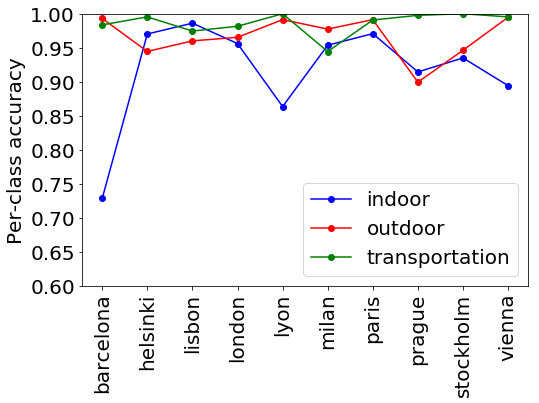

In [50]:

f1 = plt.figure(figsize=(8,5))
plt.plot(cities,Recalls_by_class[:,0],'o-b')
plt.plot(cities,Recalls_by_class[:,1],'o-r')
plt.plot(cities,Recalls_by_class[:,2],'o-g')
plt.legend(ClassNames,fontsize=20)
plt.ylim([0.6,1])
plt.xticks(rotation='vertical',fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Per-class accuracy',fontsize=20)
plt.show()